# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


## Import setup

In [79]:
# Load pickled data
import pickle
import os
import glob
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline       

from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix 

import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten


output_path = "saved_model"

---
## Load The Data

In [80]:


# Dataset Collection
dataset_dir = os.path.join('..','traffic-signs-data')
training_file = os.path.join(dataset_dir, 'train.p')
validation_file= os.path.join(dataset_dir, 'valid.p')
testing_file = os.path.join(dataset_dir, 'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Basic Summary of the Data Set 

In [133]:

training_set_samples_loaded = np.array(X_train)
validation_set_samples = np.array(X_valid)
test_set_samples = np.array(X_test)

training_set_labels = np.array(y_train)
validation_set_labels = np.array(y_valid)
test_set_labels = np.array(y_test)

train_sizes_vect = np.array(train['sizes'])
train_coords_vect = np.array(train['coords'])

# Number of training examples
n_train = training_set_samples_loaded.shape[0]

# Number of validation examples
n_validation = validation_set_samples.shape[0]

# Number of testing examples.
n_test = test_set_samples.shape[0]

# What's the shape of an traffic sign image?
image_shape = (training_set_samples_loaded.shape[1:])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(training_set_labels))

# Assert lenghts of x,y arrays are consistent
assert(len(training_set_samples_loaded) == len(training_set_labels))
assert(len(validation_set_samples) == len(validation_set_labels))
assert(len(test_set_samples) == len(test_set_labels))


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


## Exploratory visualization of the dataset

Two visualiations are provided:

- Class by Class image visualization
- Training Set, Validation Set, Test Set balancing
- Training Set Piechart

Class by Class visualization


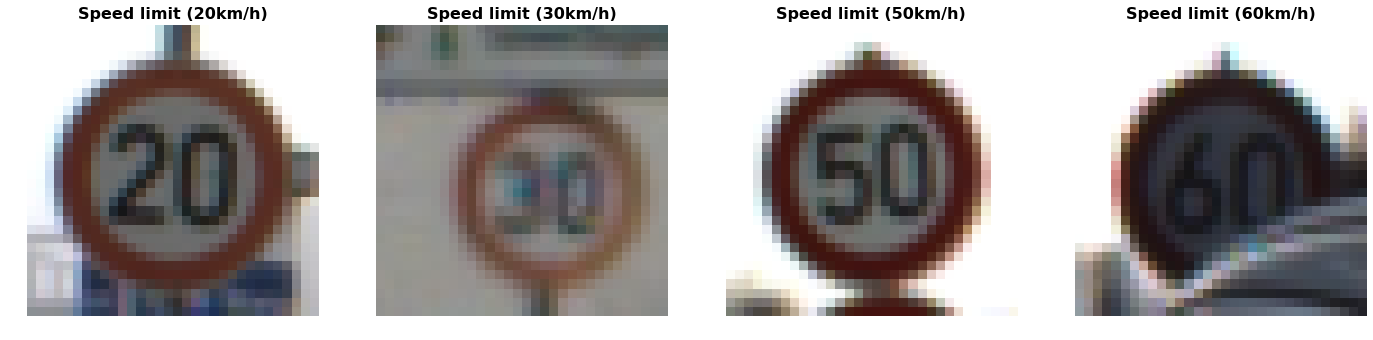

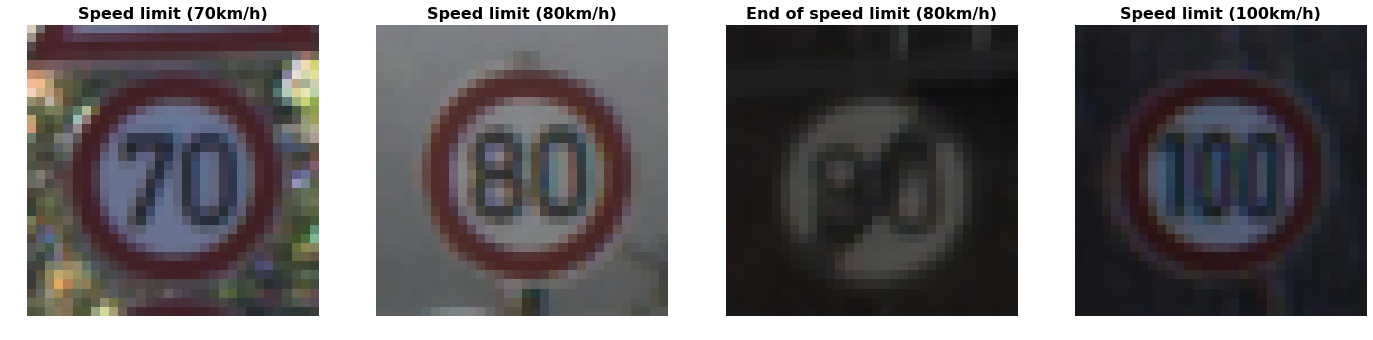

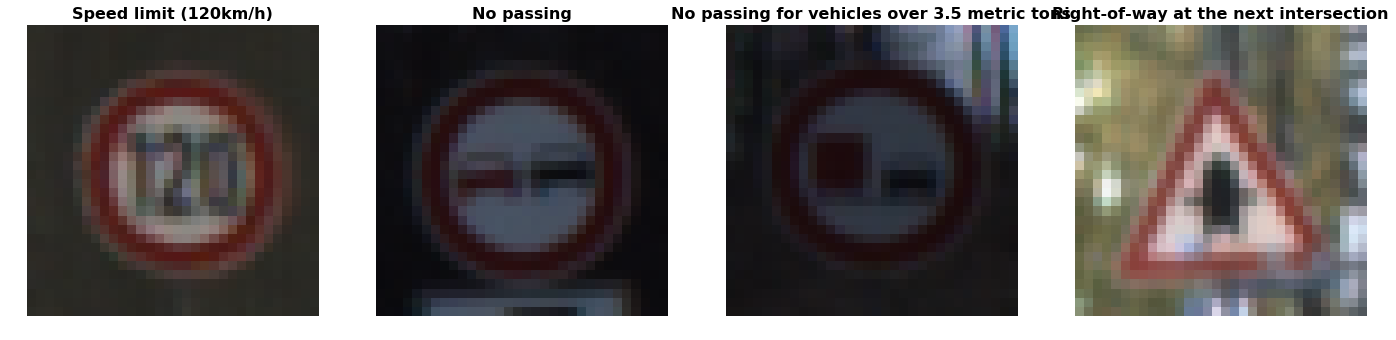

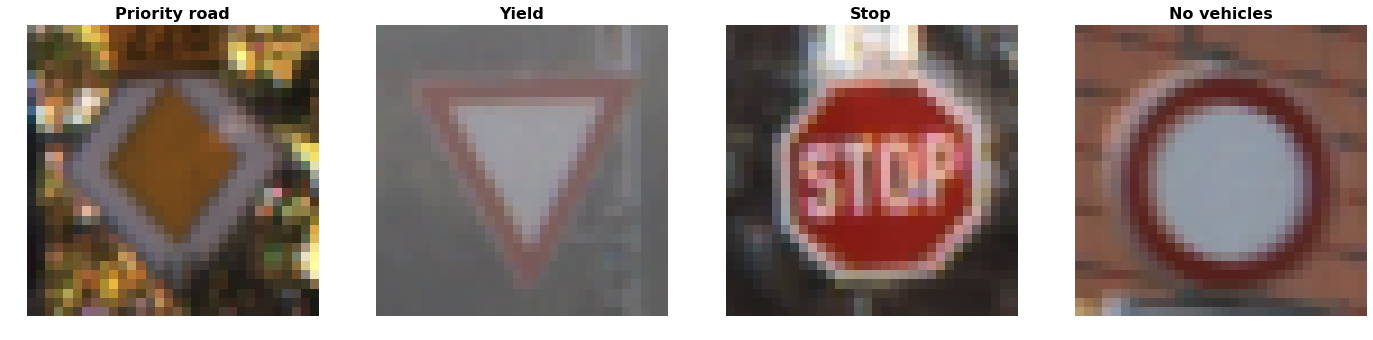

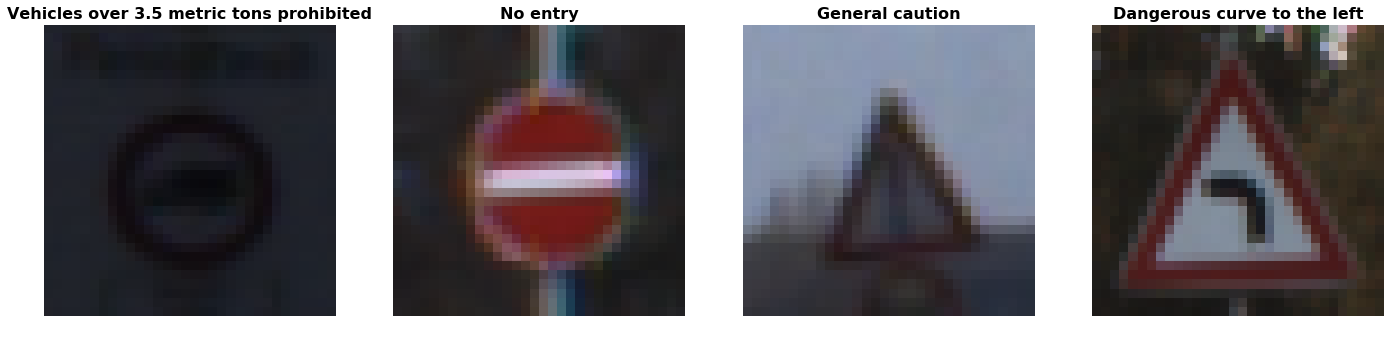

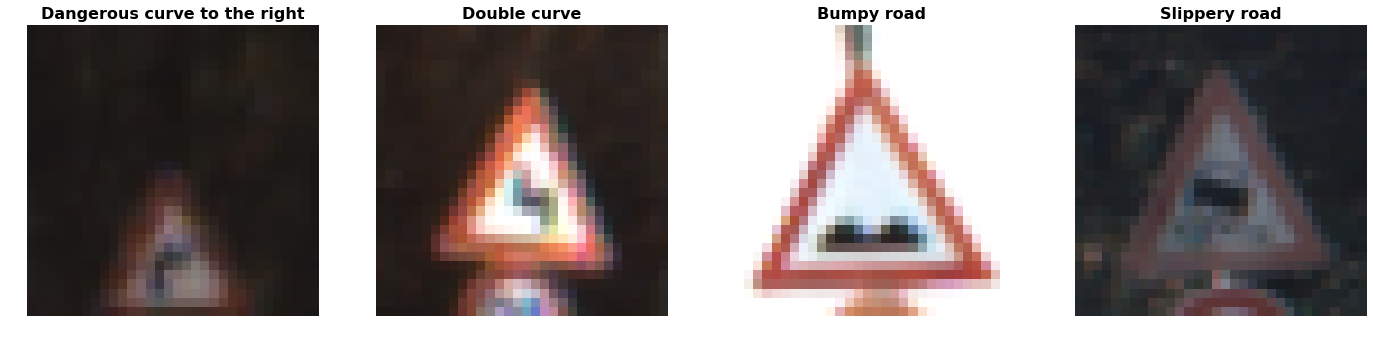

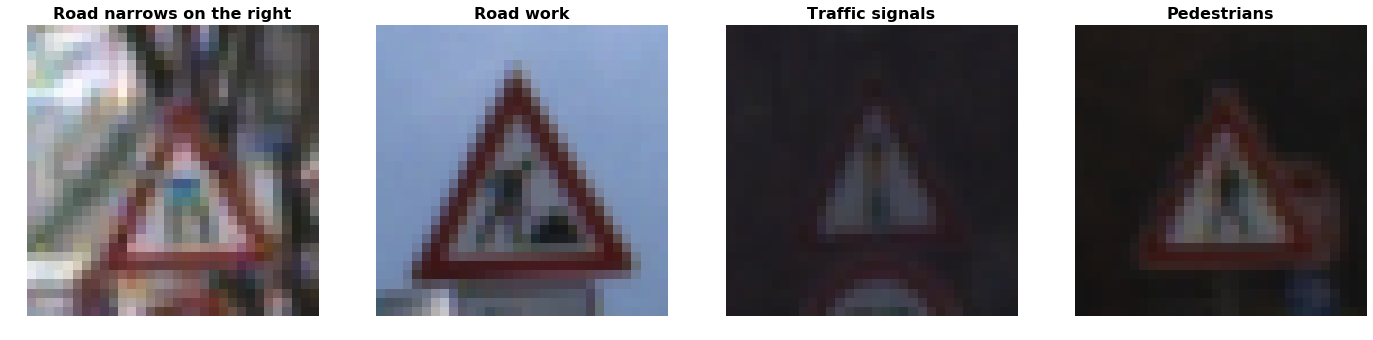

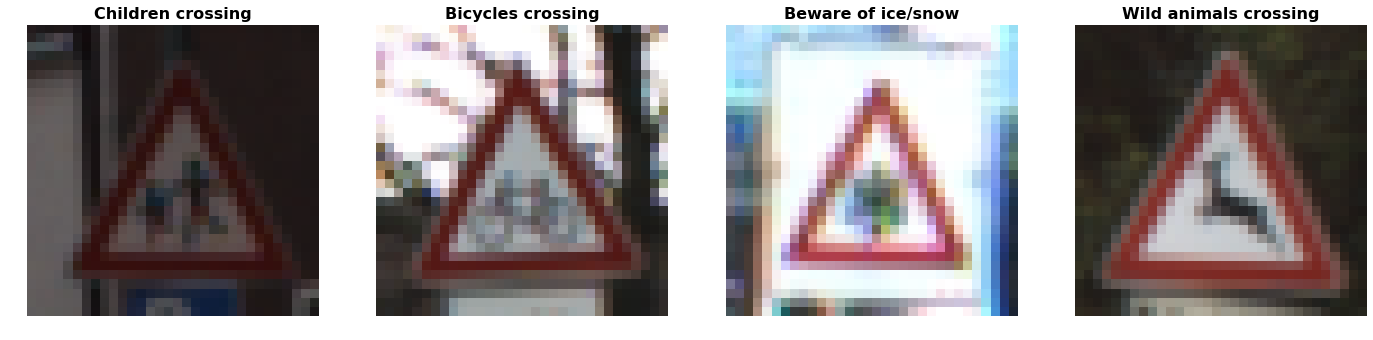

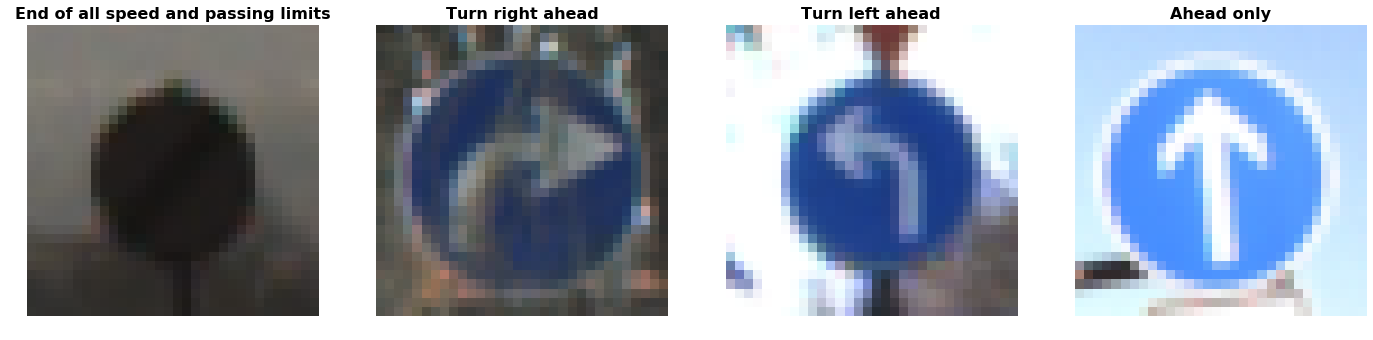

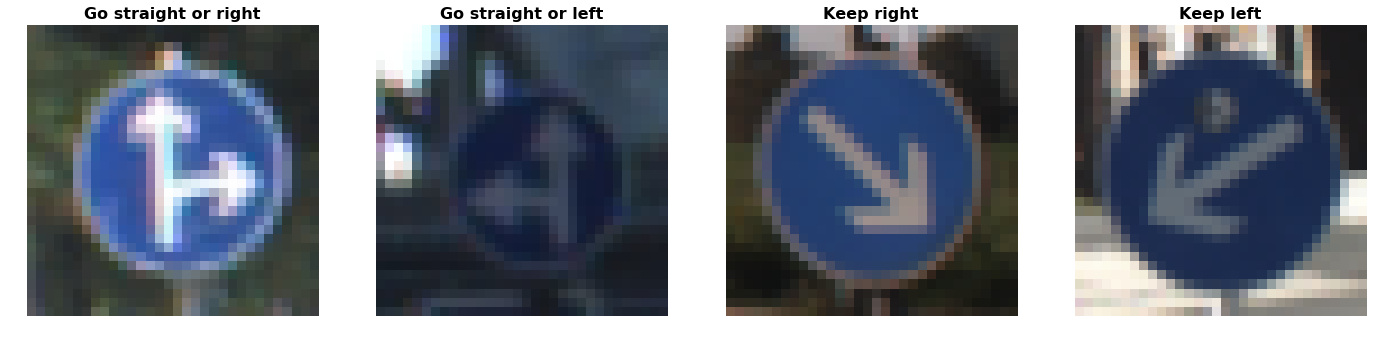

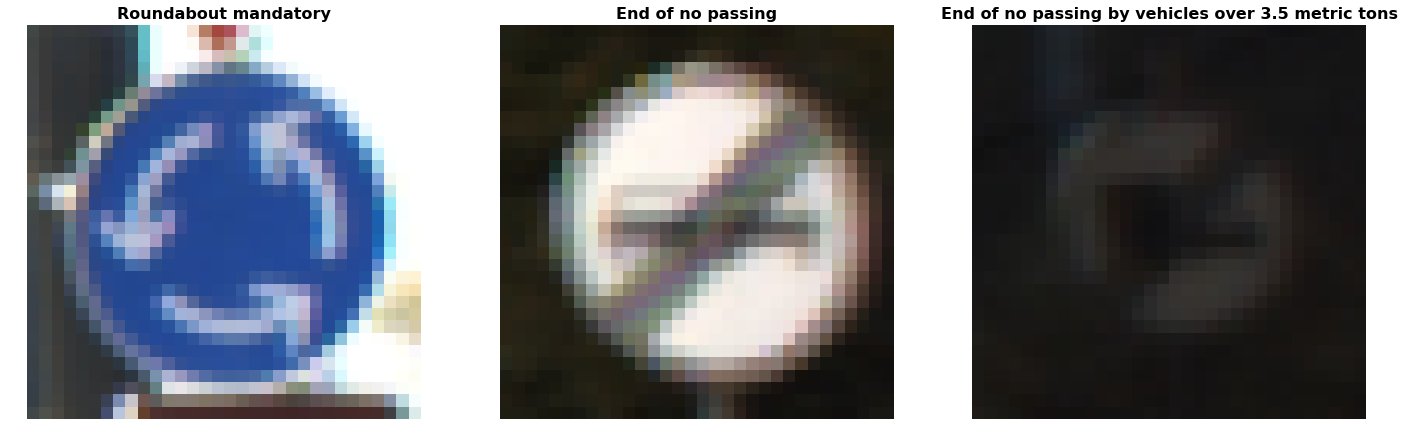

In [132]:
### Class by Class image visualization

def plot_dataset(dataset, labels):
    
    ROW_SIZE = 11
    COL_SIZE = 4
    dataset_index = 0
    for row in range(ROW_SIZE):
        col_limit = COL_SIZE if dataset_index + COL_SIZE < len(dataset) else len(dataset) - dataset_index
        
        f, axes = plt.subplots(1, col_limit, figsize=(24,24))
        
        for col in range(col_limit):
            axes[col].imshow(dataset[dataset_index])
            axes[col].set_title(labels[dataset_index], {'fontsize': 16,'fontweight' : 'bold'})
            axes[col].axis('off')
            dataset_index += 1


def plot_images(images, labels=None):
    f,axes = plt.subplots(1, len(images), figsize=(24,24))
    for ind,image in enumerate(images):
        if image.shape[-1]==1:
            axes[ind].imshow(image.squeeze(axis=2), cmap='gray')
            if labels is not None:
                axes[ind].set_title(labels[ind], {'fontsize': 16,'fontweight' : 'bold'}) 
        else:
            axes[ind].imshow(image)
            if labels is not None:
                axes[ind].set_title(labels[ind], {'fontsize': 16,'fontweight' : 'bold'})
    
    plt.show()
        


# labels loaded as pandas DataFrame
labels = pd.read_csv('signnames.csv')

labels_idx = labels.index
labels_cols = labels.columns
labels_vals = labels.values

class_labels = labels['SignName'].values

indices = list()
for index in np.unique(training_set_labels):
    label_indices = np.where(training_set_labels==index)[0]
    indices.append(label_indices[0])
    
sample_images = training_set_samples_loaded[indices]
sample_labels = class_labels[training_set_labels[indices]]

print('Class by Class visualization')
plot_dataset(sample_images, sample_labels)

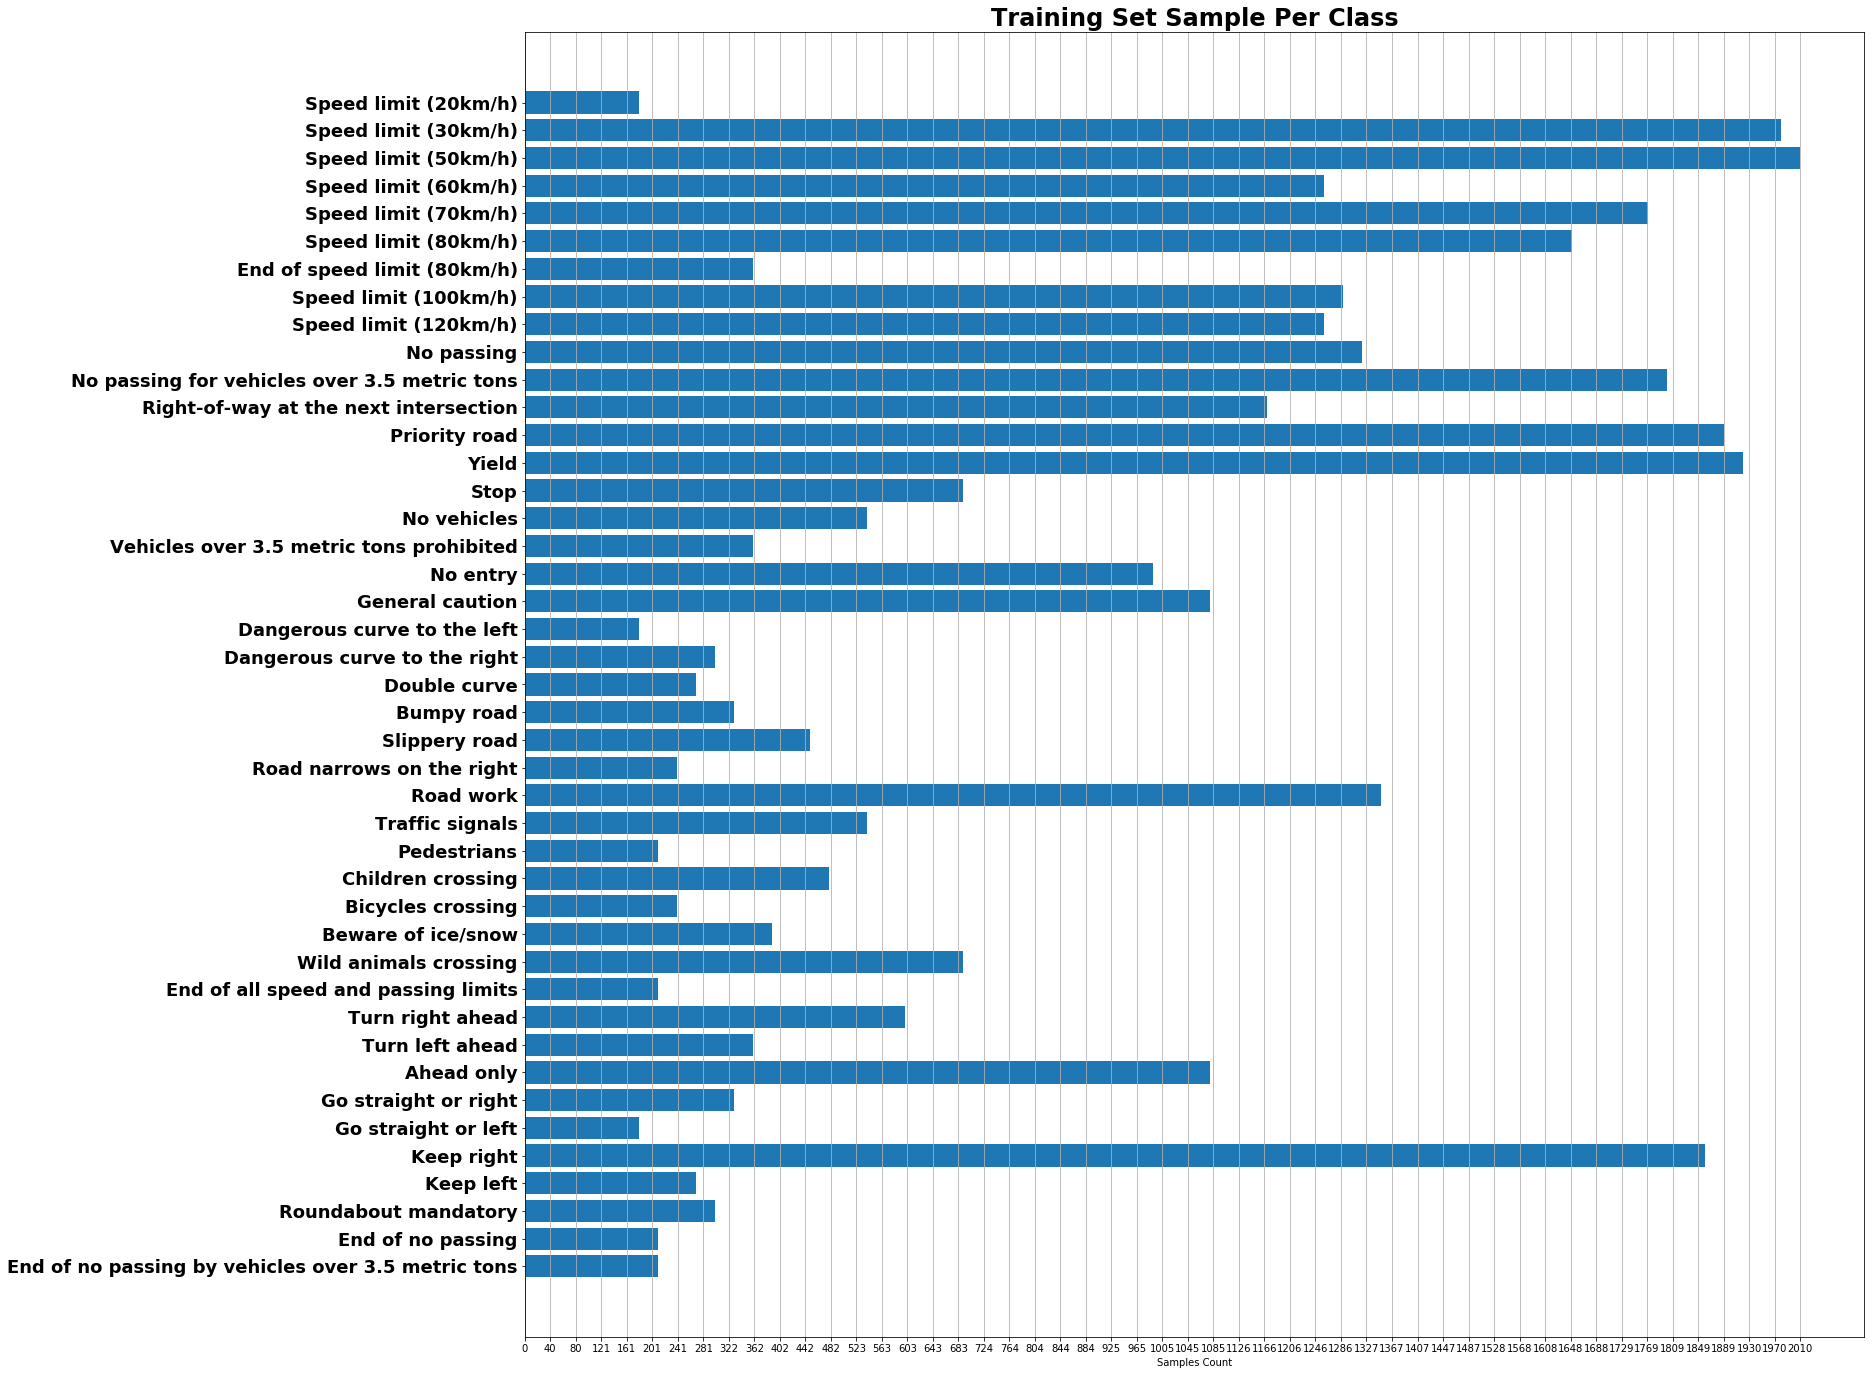

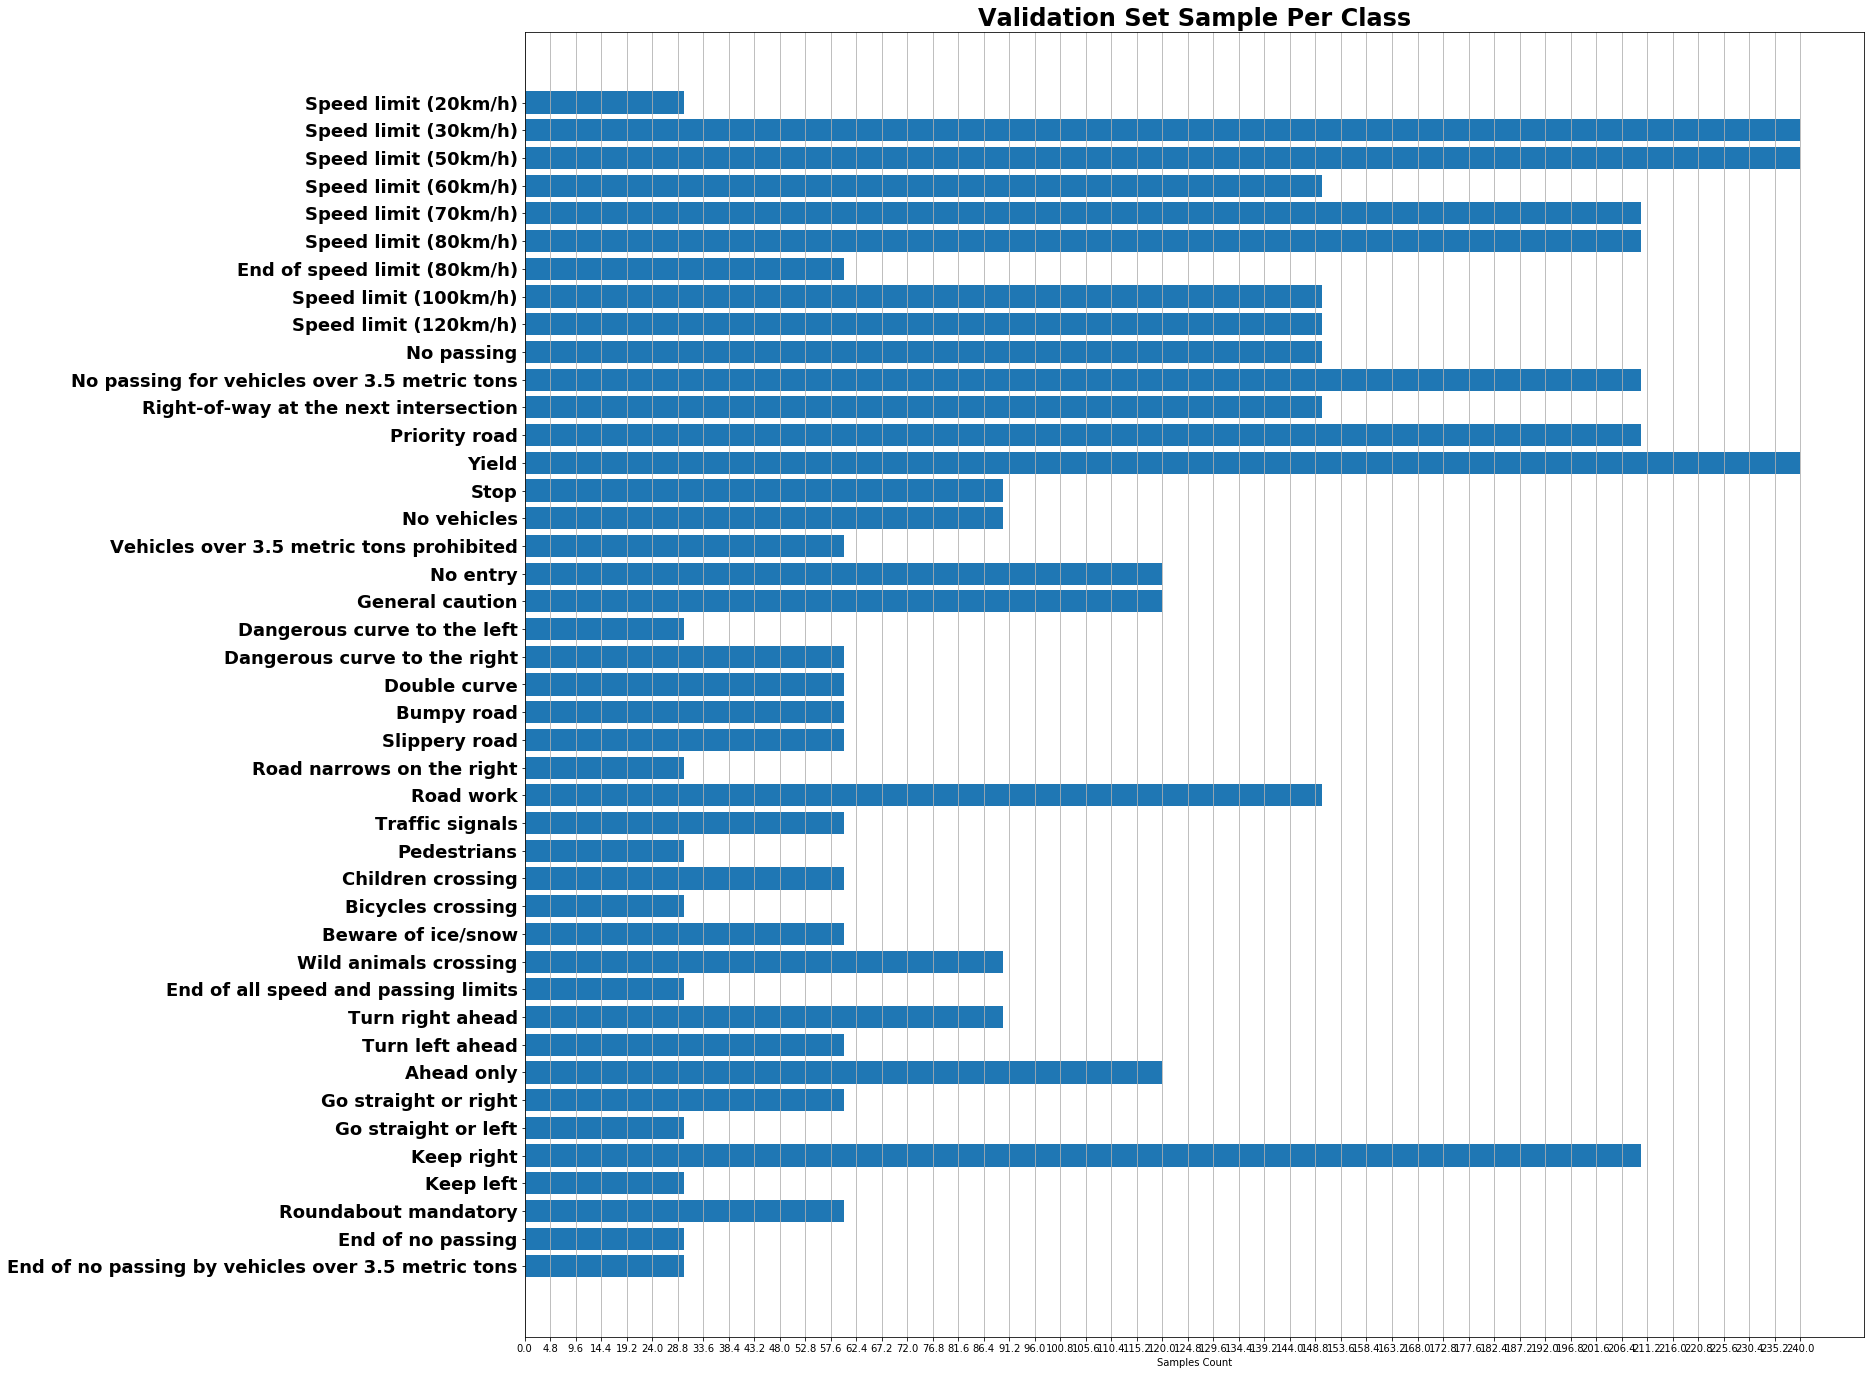

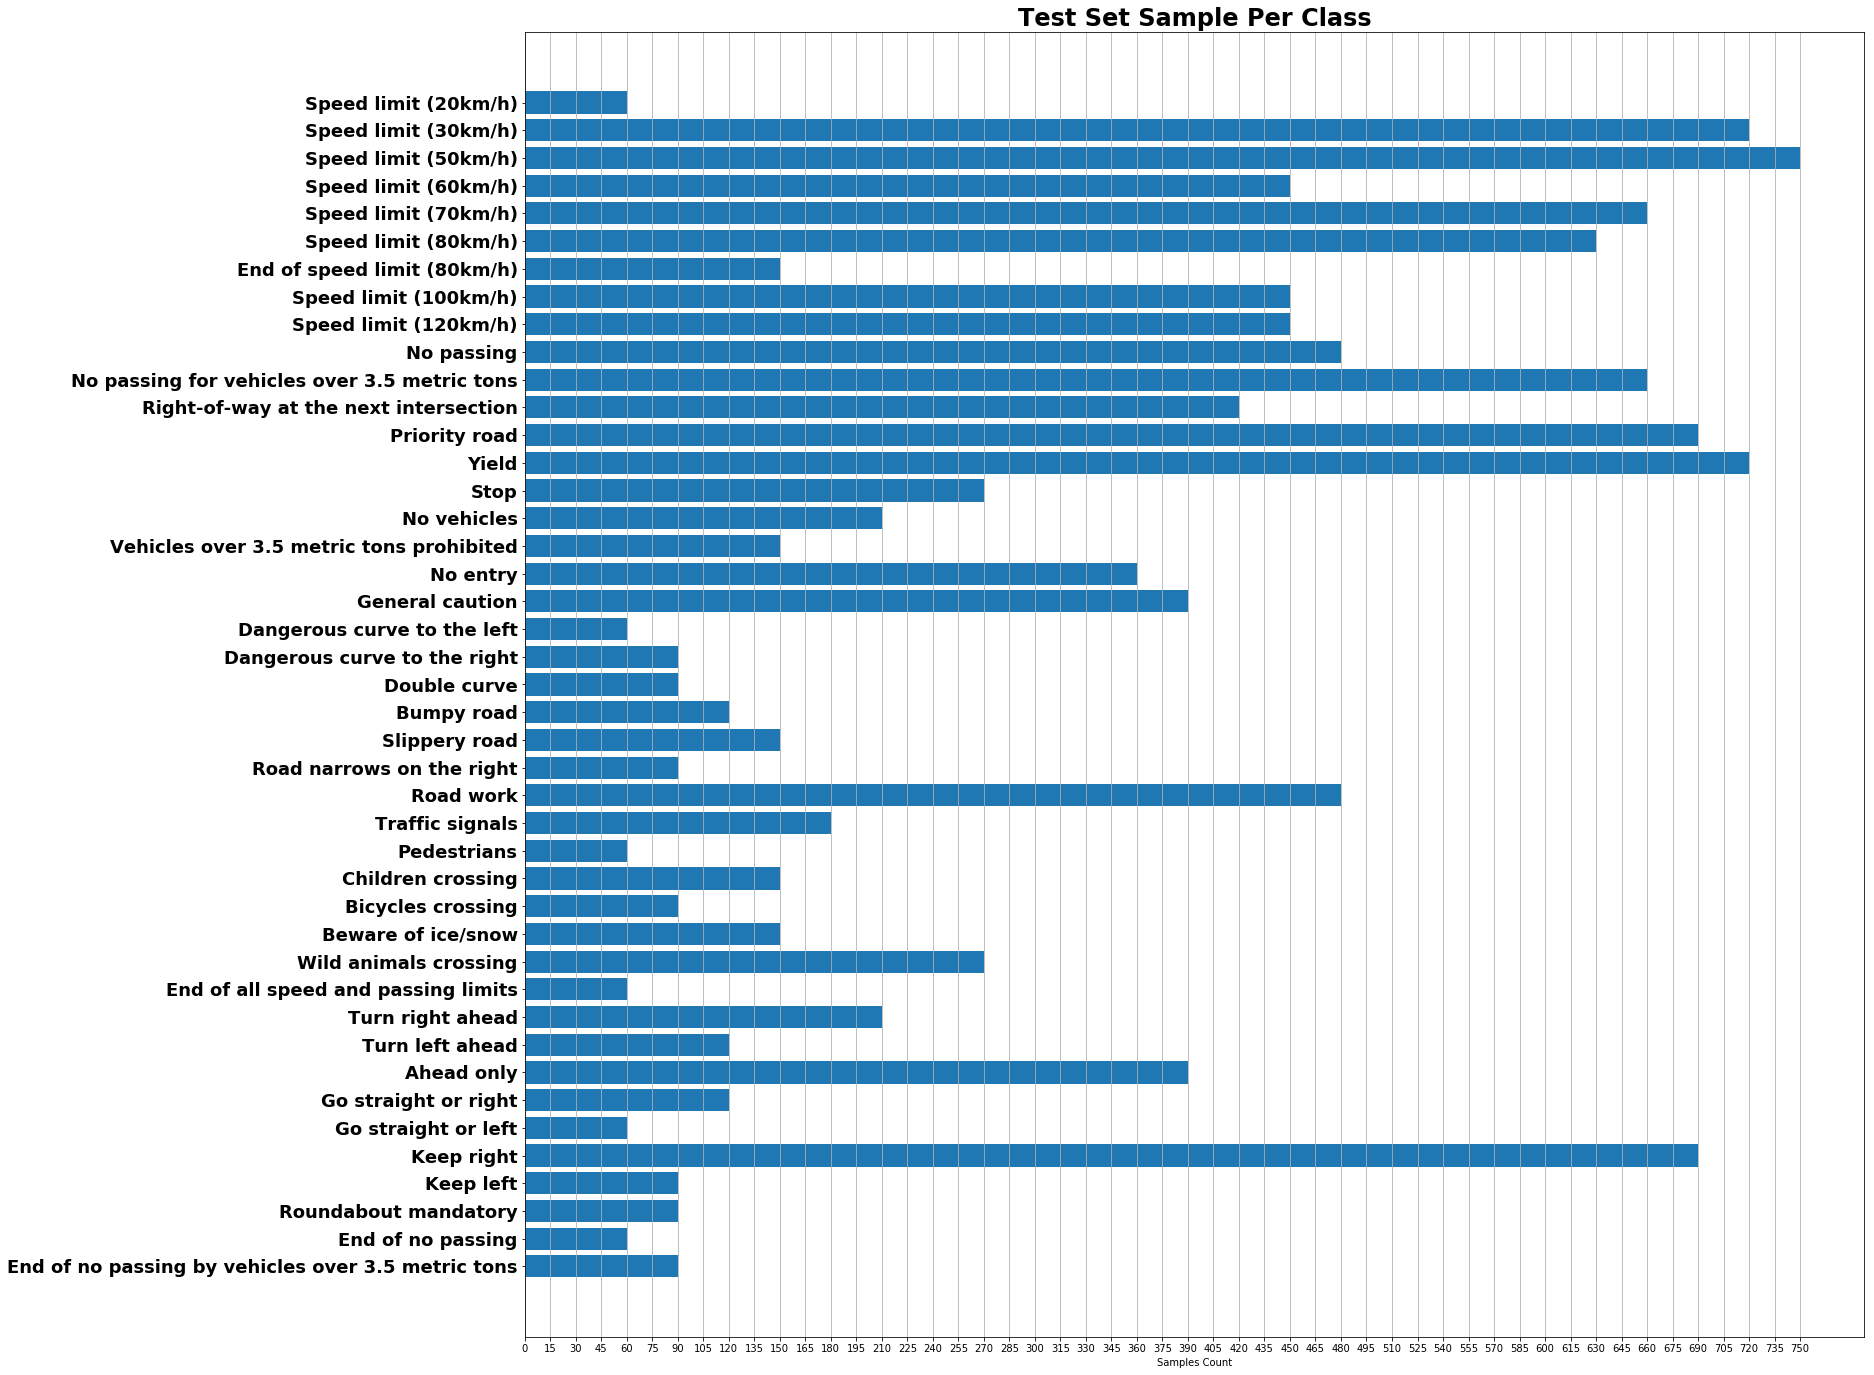

In [83]:
# Dataset Balancing inspection

def show_set_balancing(set_labels, name='Generic Set'):
    (unique, counts) = np.unique(set_labels, return_counts=True)
    class_counts = np.asarray((unique, counts)).T
    
    # Label position arangement
    label_pos = np.arange(len(class_labels))
    
    f, ax = plt.subplots(figsize=(24,24))
    ax.barh(unique, counts, align='center')
    
    # Major ticks every 50
    major_ticks = np.arange(0, max(counts)+1, max(counts)/50)
    ax.set_xticks(major_ticks)

    ax.grid(axis='x')
    ax.set_yticks(label_pos)
    ax.set_yticklabels(class_labels, {'fontsize': 18,'fontweight': 'bold'})
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Samples Count')
    ax.set_title(name+' Sample Per Class', {'fontsize': 24,'fontweight': 'bold'})
    
    
show_set_balancing(training_set_labels, 'Training Set')
show_set_balancing(validation_set_labels, 'Validation Set')
show_set_balancing(test_set_labels, 'Test Set')

### Training Set Inspection 

Firstly a PieChart of training set is showed. 
Then, most and least occurring classes are listed

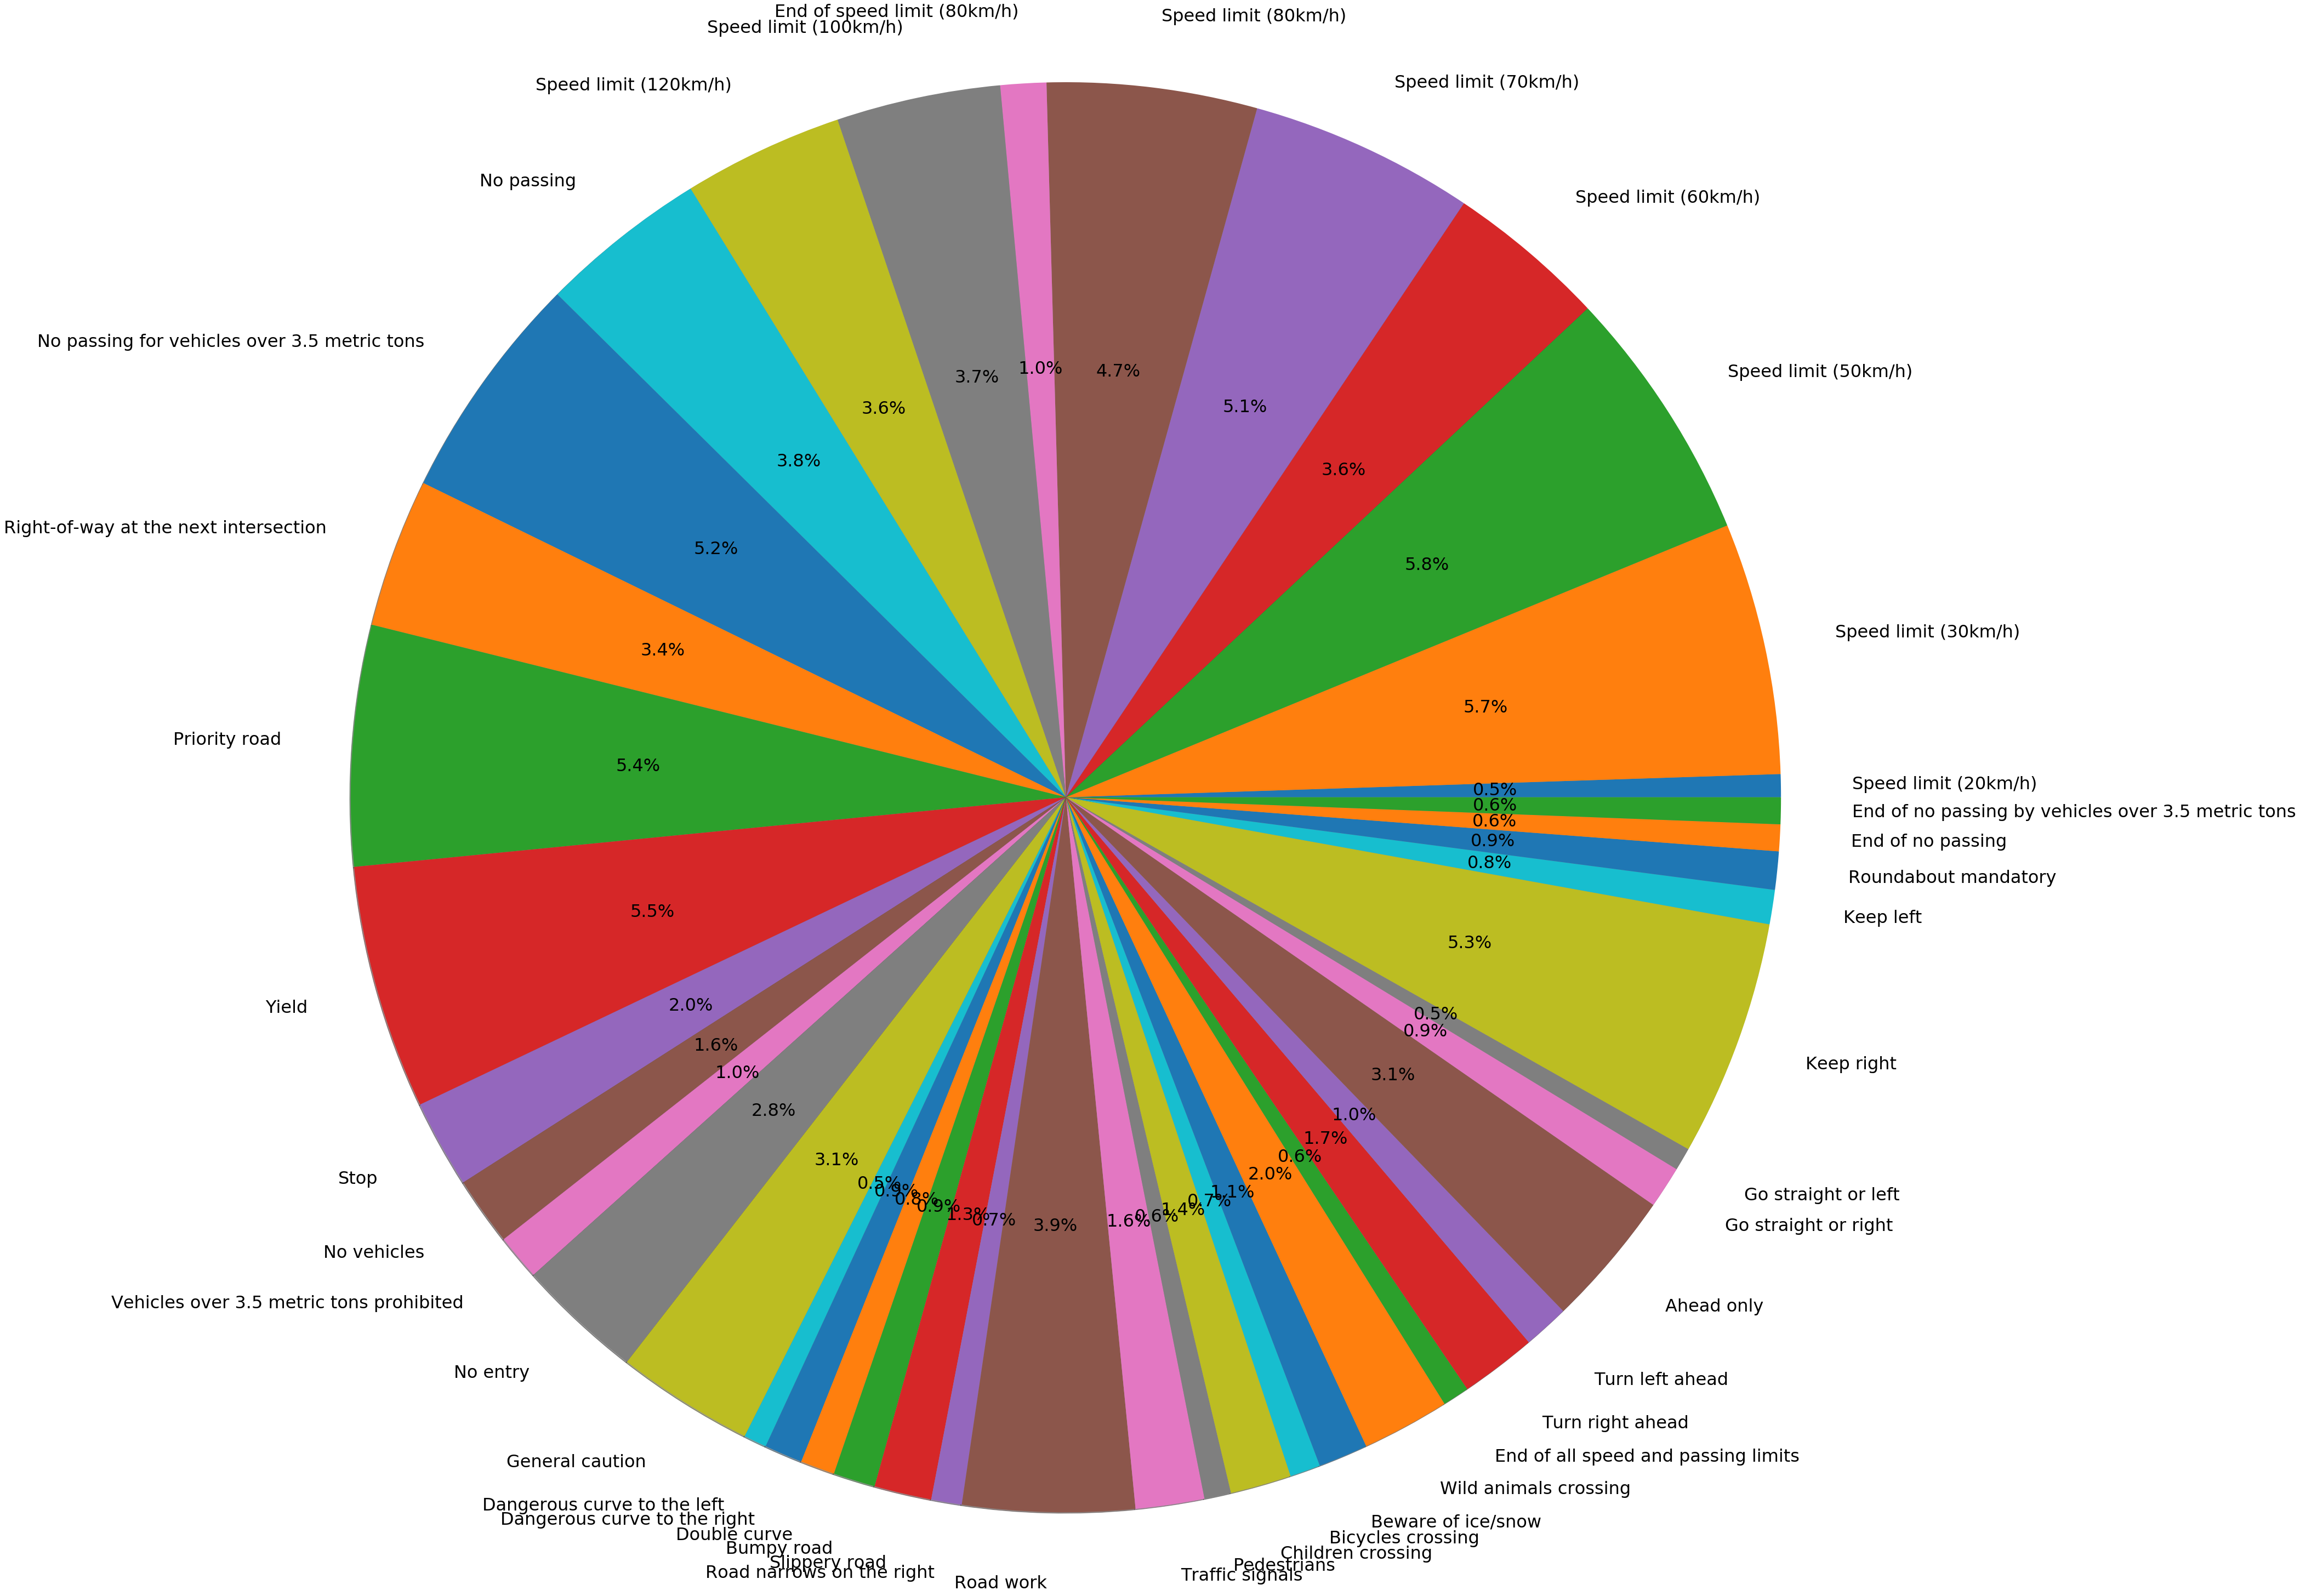

Most occurred class :  Speed limit (50km/h)  Freq: 5.776 %
Least occurred class :  Speed limit (20km/h)  Freq: 0.517 %


In [84]:

(unique, counts) = np.unique(training_set_labels, return_counts=True)
patches, texts, autotexts = plt.pie(counts, autopct='%1.1f%%', shadow=True, 
                                    labels=class_labels, textprops={'fontsize': 32}, radius=15)
[ _.set_fontsize(32) for _ in texts ]
plt.show()


# Compute most and least occurring classes
class_frequencies = np.asarray((unique, counts/n_train)).T

most_occurred = max(class_frequencies, key=lambda x:x[1])
least_occurred = min(class_frequencies, key=lambda x:x[1])

print('Most occurred class : ', class_labels[int(most_occurred[0])], " Freq: {:.3f} %".format(most_occurred[1]*100.0))
print('Least occurred class : ', class_labels[int(least_occurred[0])], " Freq: {:.3f} %".format(least_occurred[1]*100.0))

## Considerations

The dataset seems highly imbalanced. This should be taken into account for improving its performance.

There could be tried some balancing technique such as

 1. Class Weights
 2. Oversampling

An useful link where these techniques are showed in TensorFlow is 

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. 

Train and test model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 

## Pre-process the Data Set 

Shuffle the training data.


In [85]:
# Shuffling
training_set_samples_loaded, training_set_labels = shuffle(training_set_samples_loaded, training_set_labels)

## Image Preprocessing

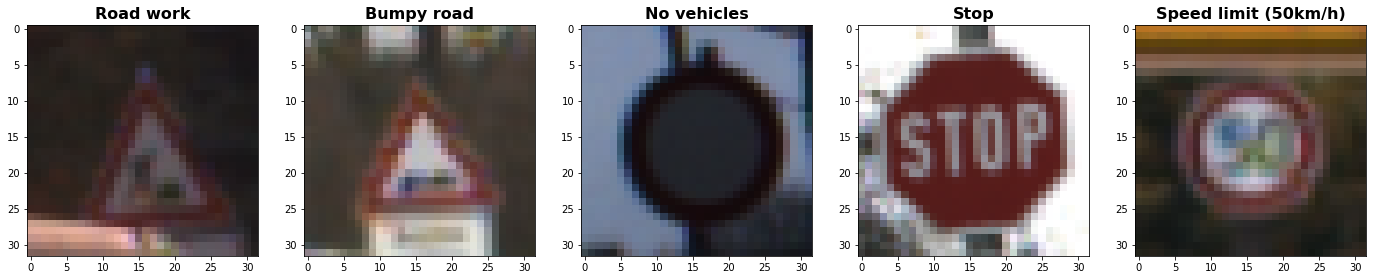

<Figure size 432x288 with 0 Axes>

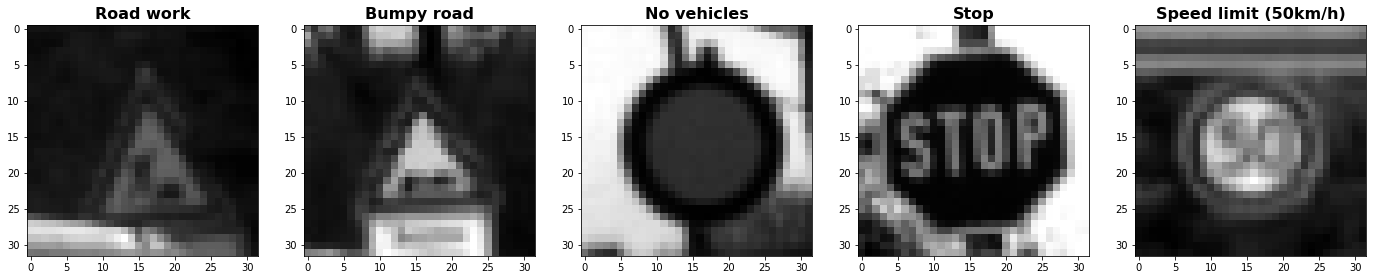

<Figure size 432x288 with 0 Axes>

In [130]:

def preprocess_image(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    pixels = np.asarray(gray)
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # compute mean std
    mean, std = pixels.mean(), pixels.std()
    # global standardization of pixels
    pixels = (pixels - mean) / std
    
    return pixels.reshape(32,32,1)
    
indices = list()
indices = np.random.randint(0, n_train, size=5)

sample_images = training_set_samples_loaded[indices]
plot_images(sample_images, class_labels[training_set_labels[indices]])
processed_sample_images = [preprocess_image(img) for img in sample_images]
plot_images(processed_sample_images, class_labels[training_set_labels[indices]])

## Dataset Preprocessing

In [87]:
def preprocess_dataset(dataset):
    els = [preprocess_image(img) for img in dataset]
    return np.array(els)


training_set_samples = preprocess_dataset(training_set_samples_loaded)
validation_set_samples = preprocess_dataset(validation_set_samples)
test_set_samples = preprocess_dataset(test_set_samples)
print('Preprocessing Complete!')
print('Training, Validation and Test set have been preprocessed!')


Preprocessing Complete!
Training, Validation and Test set have been preprocessed!


## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.


In [88]:

EPOCHS = 60
BATCH_SIZE = 512

##  LeNet-5 Architecture
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

### Model Implementation

In [89]:

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # ADDON: dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

## Features and Labels
Train LeNet to classify traffic signs
`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [90]:
input_size_list = list(image_shape)
input_size_list.insert(0,None)
input_size = tuple(input_size_list)

x = tf.placeholder(tf.float32, (input_size[0], input_size[1], input_size[2], 1))
print('Input layer size: ', (input_size[0], input_size[1], input_size[2], 1))

y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

Input layer size:  (None, 32, 32, 1)


## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.


In [91]:
rate = 0.00091

logits, conv1, conv2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.


In [92]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


prediction_operation = tf.argmax(logits, 1)
y_operation = tf.argmax(one_hot_y, 1)

def evaluate_prediction(X_data, y_data):
    num_examples = len(X_data)
    predictions = list()
    labels = list()

    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        predictions_val, y_val = sess.run([prediction_operation, y_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        
        predictions.extend(predictions_val)
        labels.extend(y_val)

    return predictions, labels


## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.


In [93]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    train_accuracy_history = list()
    valid_accuracy_history = list()
    loss_history = list()
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(training_set_samples, training_set_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, curr_loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(validation_set_samples, validation_set_labels)
        train_accuracy = evaluate(training_set_samples, training_set_labels)
        
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(validation_accuracy)
        loss_history.append(curr_loss)  

        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, os.path.join(output_path,'lenet'))
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.544

EPOCH 2 ...
Validation Accuracy = 0.756

EPOCH 3 ...
Validation Accuracy = 0.827

EPOCH 4 ...
Validation Accuracy = 0.864

EPOCH 5 ...
Validation Accuracy = 0.880

EPOCH 6 ...
Validation Accuracy = 0.898

EPOCH 7 ...
Validation Accuracy = 0.901

EPOCH 8 ...
Validation Accuracy = 0.914

EPOCH 9 ...
Validation Accuracy = 0.910

EPOCH 10 ...
Validation Accuracy = 0.926

EPOCH 11 ...
Validation Accuracy = 0.931

EPOCH 12 ...
Validation Accuracy = 0.927

EPOCH 13 ...
Validation Accuracy = 0.930

EPOCH 14 ...
Validation Accuracy = 0.930

EPOCH 15 ...
Validation Accuracy = 0.933

EPOCH 16 ...
Validation Accuracy = 0.943

EPOCH 17 ...
Validation Accuracy = 0.940

EPOCH 18 ...
Validation Accuracy = 0.936

EPOCH 19 ...
Validation Accuracy = 0.940

EPOCH 20 ...
Validation Accuracy = 0.944

EPOCH 21 ...
Validation Accuracy = 0.939

EPOCH 22 ...
Validation Accuracy = 0.939

EPOCH 23 ...
Validation Accuracy = 0.943

EPOCH 24 ...
Validation Accura

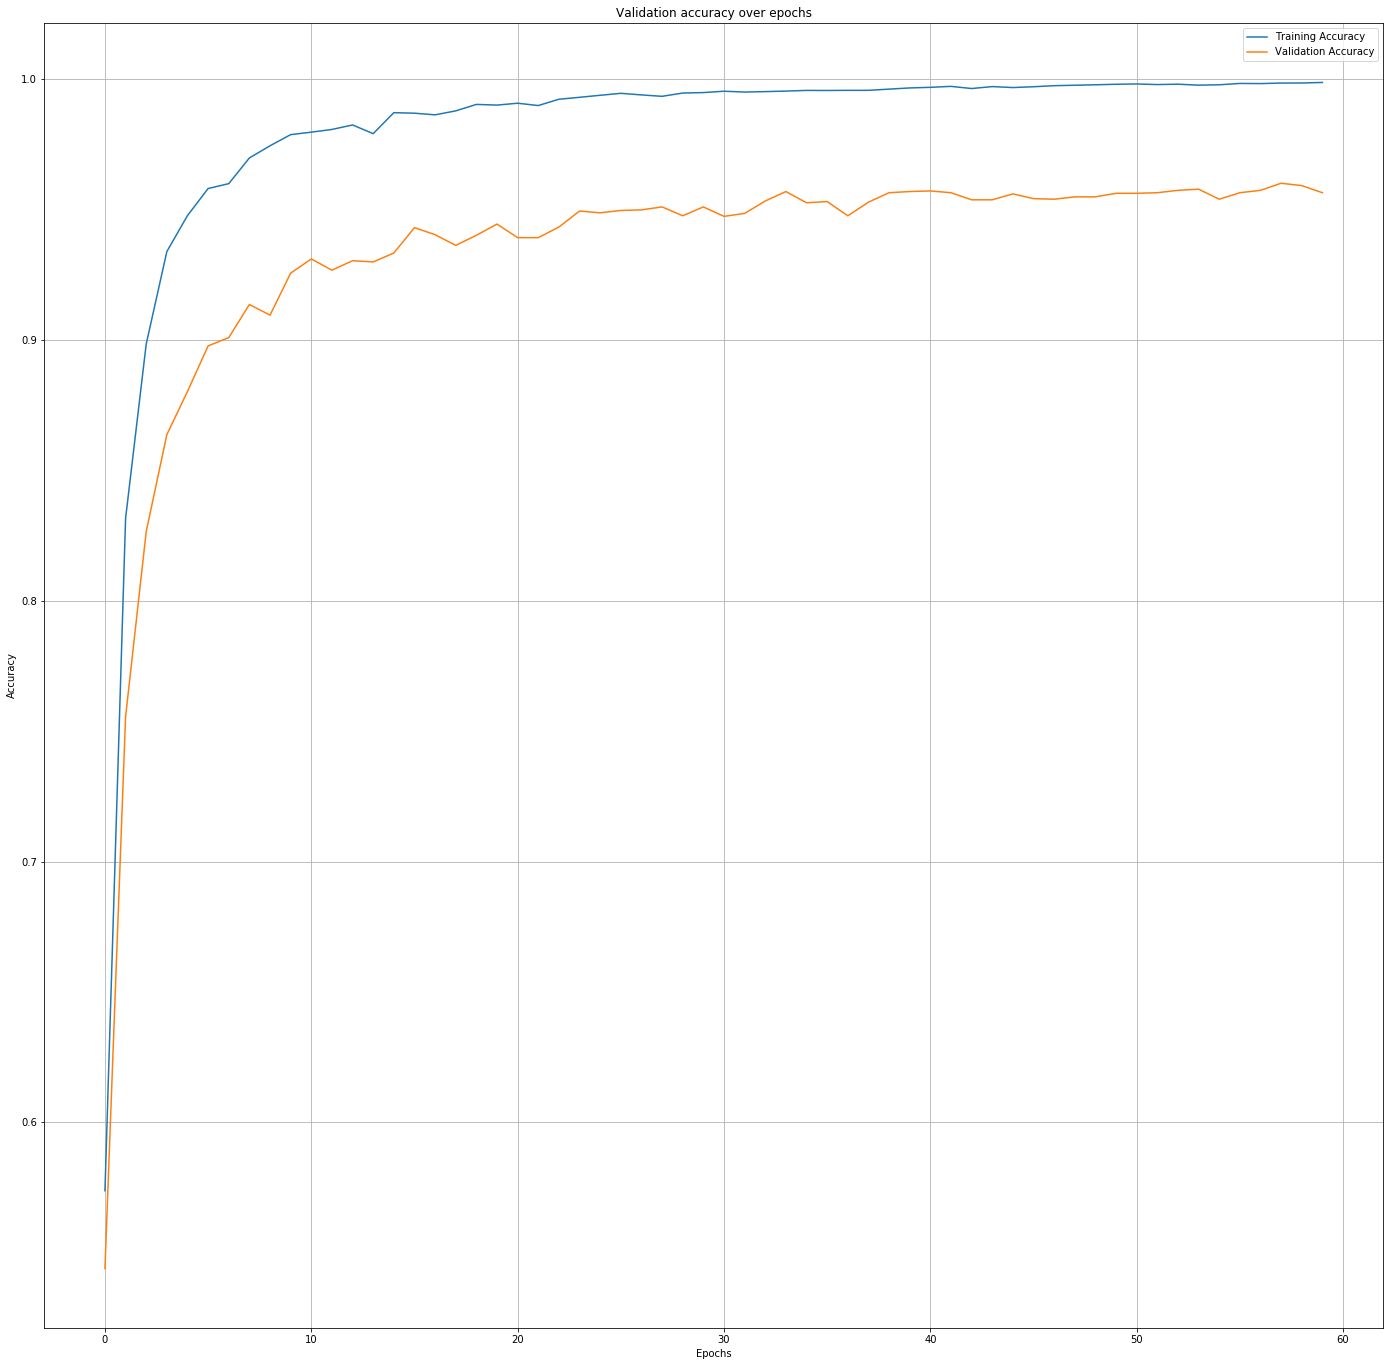

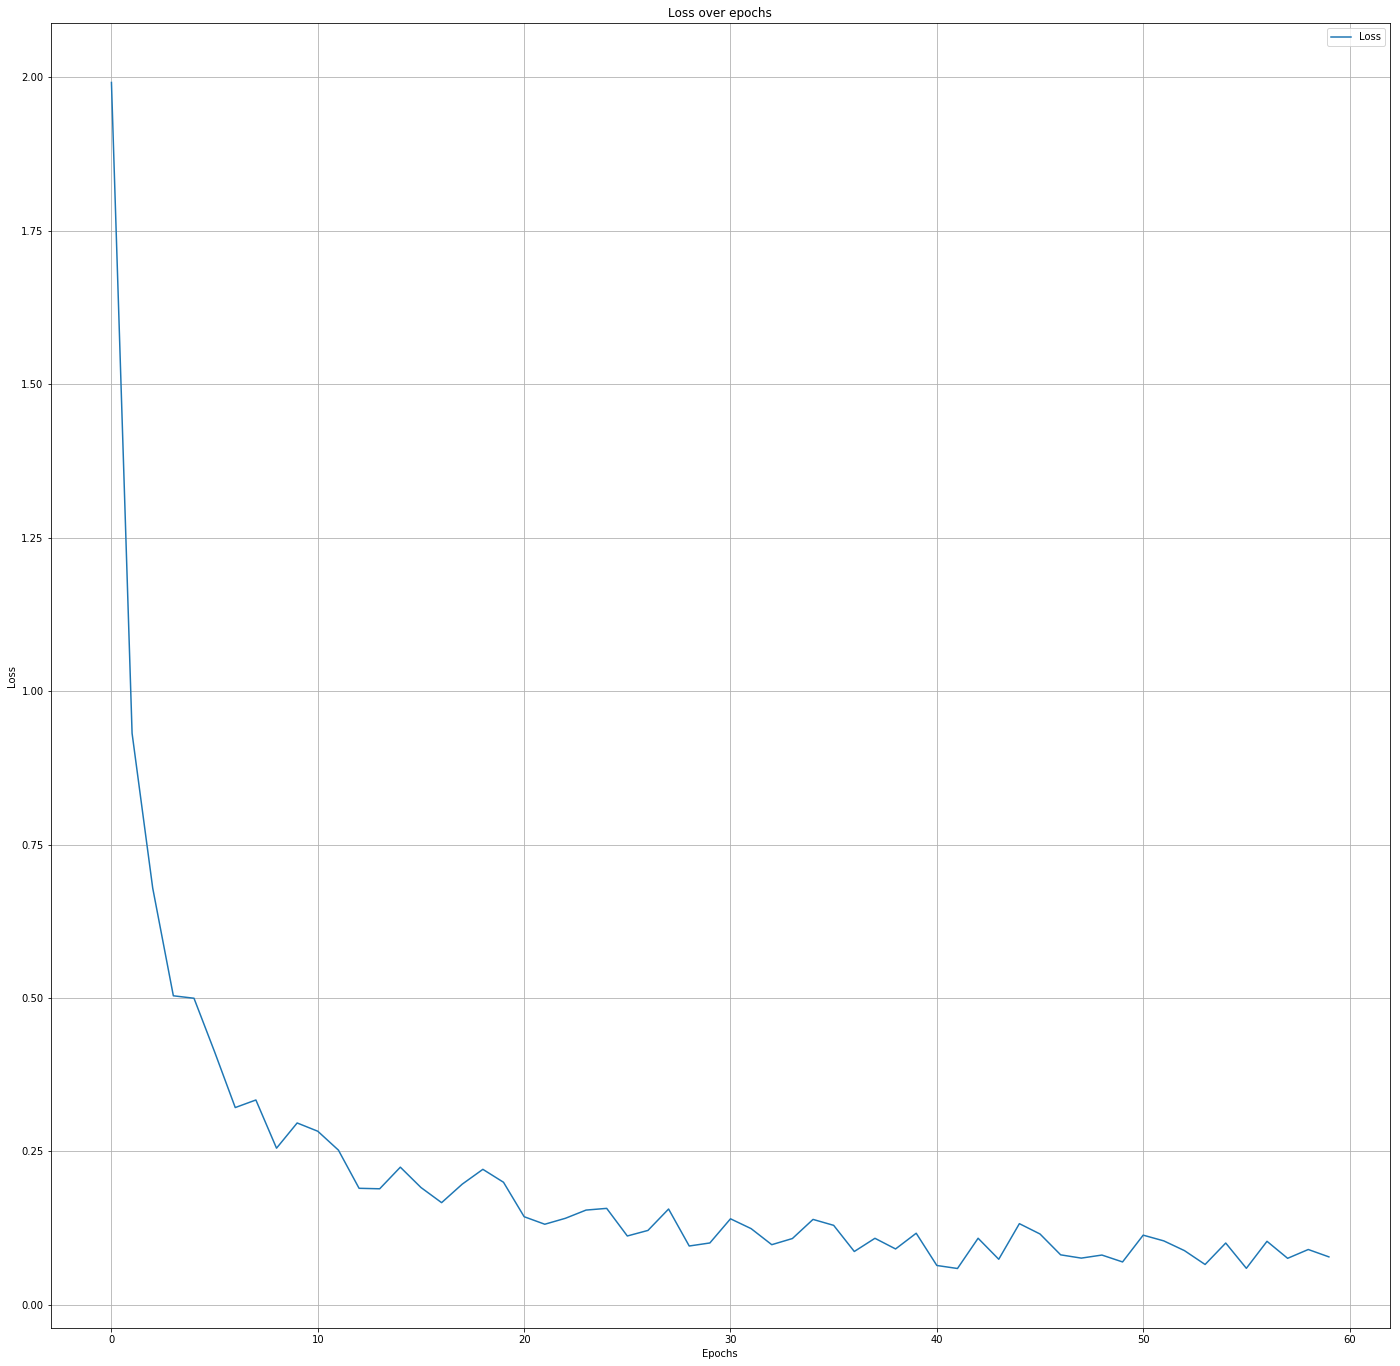

In [120]:
f,ax = plt.subplots(figsize=(24,24))

ax.plot(range(EPOCHS), train_accuracy_history, label='Training Accuracy')
ax.grid()
ax.set_title('Training accuracy over epochs')

ax.plot(range(EPOCHS), valid_accuracy_history, label='Validation Accuracy')
ax.set_title('Validation accuracy over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

f,ax = plt.subplots(figsize=(24,24))

ax.plot(range(EPOCHS), loss_history, label='Loss')
ax.grid()
ax.legend()
ax.set_title('Loss over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')



## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.


In [95]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(output_path))

    training_set_accuracy = evaluate(training_set_samples, training_set_labels)
    print("Training Set Accuracy = {:.3f}".format(training_set_accuracy))
    
    validation_set_accuracy = evaluate(validation_set_samples, validation_set_labels)
    print("Validation Set Accuracy = {:.3f}".format(validation_set_accuracy))
    
    test_accuracy = evaluate(test_set_samples, test_set_labels)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from saved_model/lenet
Training Set Accuracy = 0.999
Validation Set Accuracy = 0.956
Test Set Accuracy = 0.948


## Considerations

These results are above target accuracy of 0.93 on validation set.

In order to have a deeper understanding on training result, some more detailed metrics are computed:

- **Precision** : this talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.
    
    *Having an High Precision limit the cost of a False Positive*


- **Recall** actually calculates how many of the Actual Positives our model capture through labeling it as Positive

    *Having High Recall limit the cost of False Negative*


- **F1 Score** is a measure to use if we need to seek a balance between Precision and Recall

These values are shown class by class

Moreover, Confusion Matrix is computed and showed as image.

**Confusion matrix**

- It is a summary of prediction results on a classification problem. 
- It shows the ways in which a classification model is confused when it makes predictions. 
- It gives insight not only into the errors being made by a classifier but more importantly the types of errors that are being made.

## Training Metrics

Print the confusion matrix for showing dependancies between classifications

INFO:tensorflow:Restoring parameters from saved_model/lenet


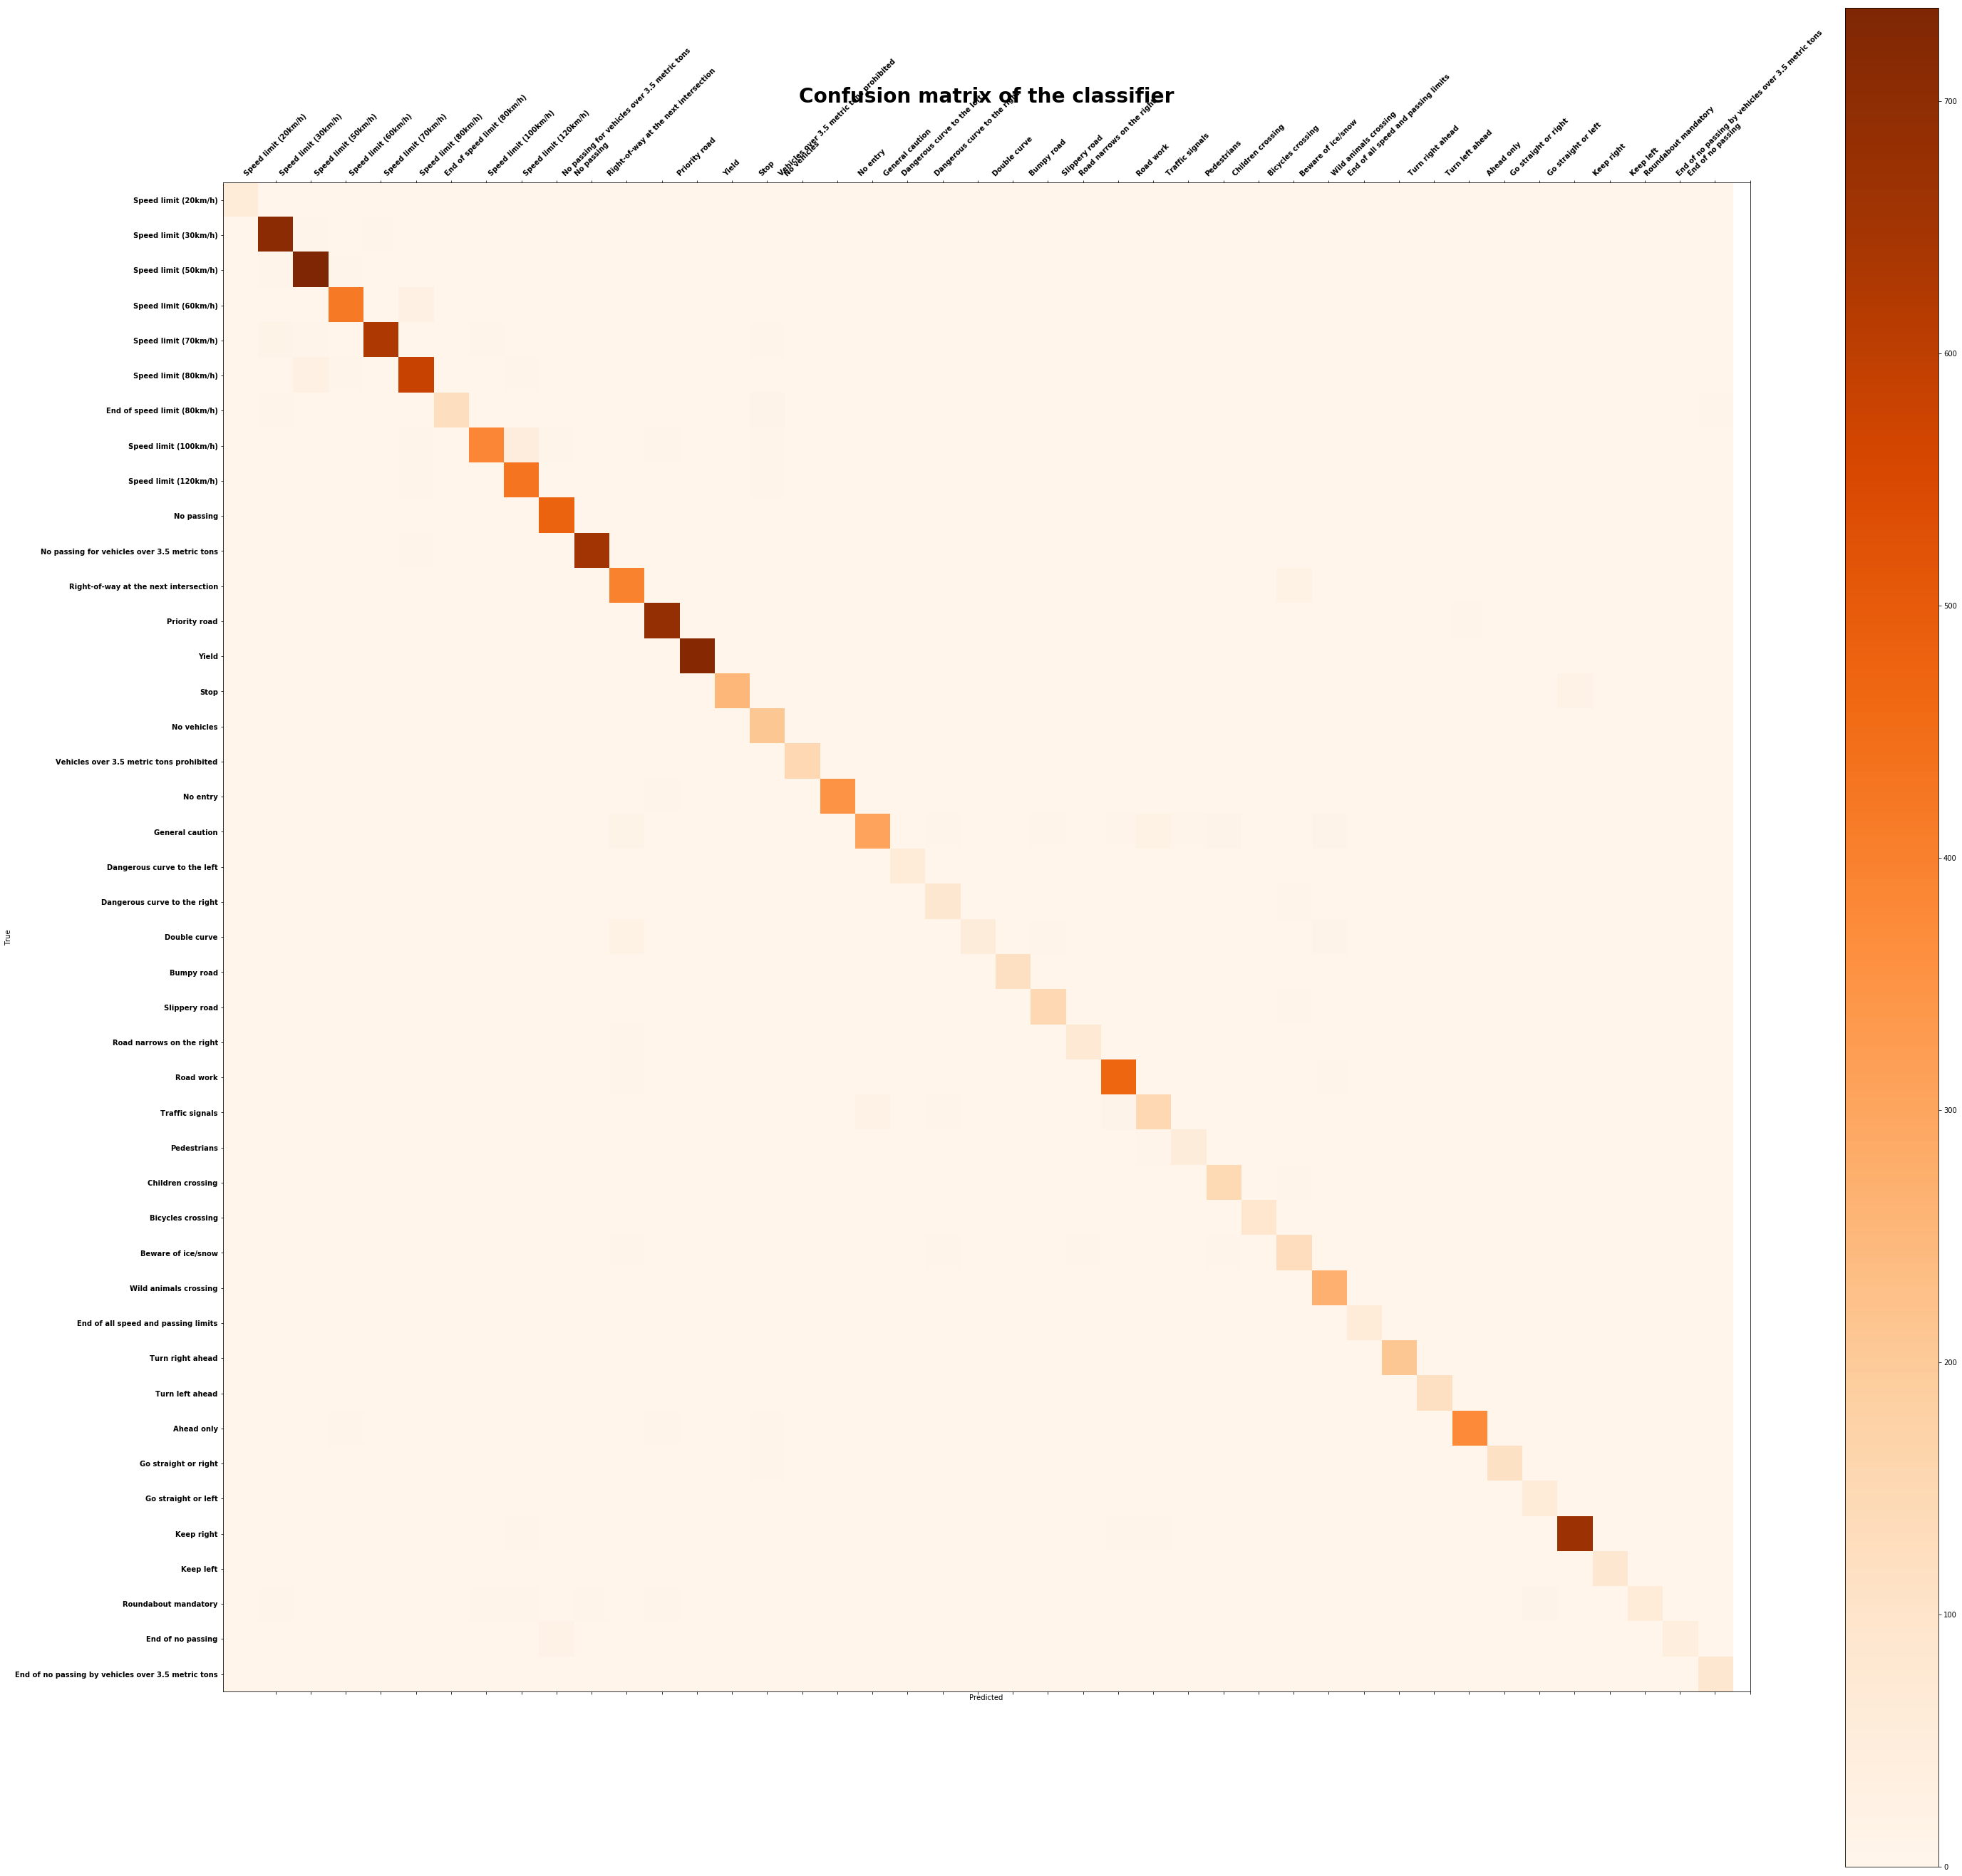

<Figure size 432x288 with 0 Axes>

In [121]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(output_path))
    y_pred, y_true = evaluate_prediction(test_set_samples, test_set_labels)
    


test_pred = np.array(y_pred)
test_true = np.array(y_true)
cm = metrics.confusion_matrix(test_true, test_pred)
#print()
fig = plt.figure(figsize=(48,48))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Oranges)
plt.title('Confusion matrix of the classifier', {'fontsize':28, 'fontweight':'bold'})
fig.colorbar(cax)

ax.set_xticks(np.arange(1, n_classes+1, 1))
ax.set_yticks(np.arange(0, n_classes, 1))
plt.xticks(rotation=45)

ax.set_xticklabels(class_labels, {'fontweight':'bold'})
ax.set_yticklabels(class_labels, {'fontweight':'bold'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [97]:
# Print the precision and recall, among other metrics
classification_report = metrics.classification_report(test_true, test_pred, 
                                                      digits=3, target_names=class_labels,
                                                     output_dict=True)

print(metrics.classification_report(test_true, test_pred, digits=3, target_names=class_labels))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)      1.000     0.983     0.992        60
                              Speed limit (30km/h)      0.949     0.986     0.967       720
                              Speed limit (50km/h)      0.960     0.983     0.971       750
                              Speed limit (60km/h)      0.946     0.933     0.940       450
                              Speed limit (70km/h)      0.991     0.955     0.972       660
                              Speed limit (80km/h)      0.926     0.927     0.926       630
                       End of speed limit (80km/h)      1.000     0.820     0.901       150
                             Speed limit (100km/h)      0.965     0.847     0.902       450
                             Speed limit (120km/h)      0.871     0.958     0.912       450
                                        No passing      0.960     0.994     0.9

Here an inspection of classes with worst f1-score are shown

Traffic signals
{'f1-score': 0.818, 'precision': 0.813, 'recall': 0.822, 'support': 180}


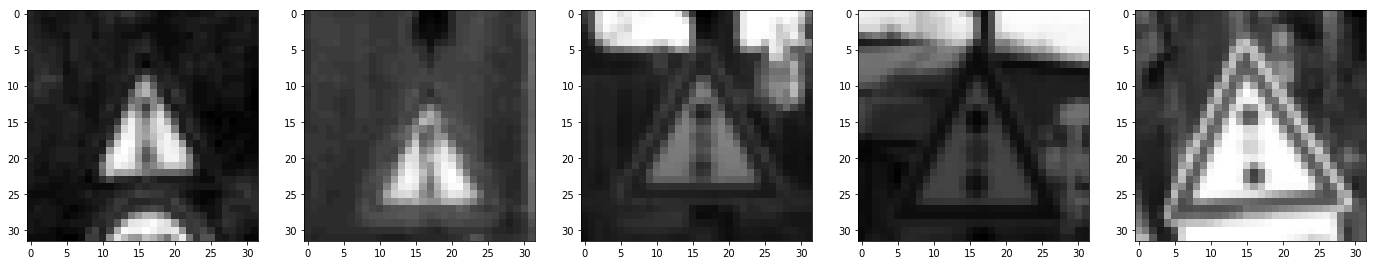

Dangerous curve to the right
{'f1-score': 0.85, 'precision': 0.796, 'recall': 0.911, 'support': 90}


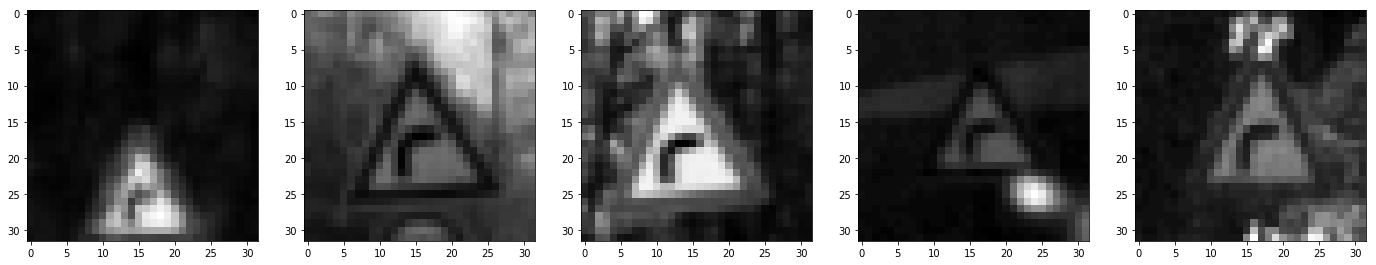

Roundabout mandatory
{'f1-score': 0.753, 'precision': 0.982, 'recall': 0.611, 'support': 90}


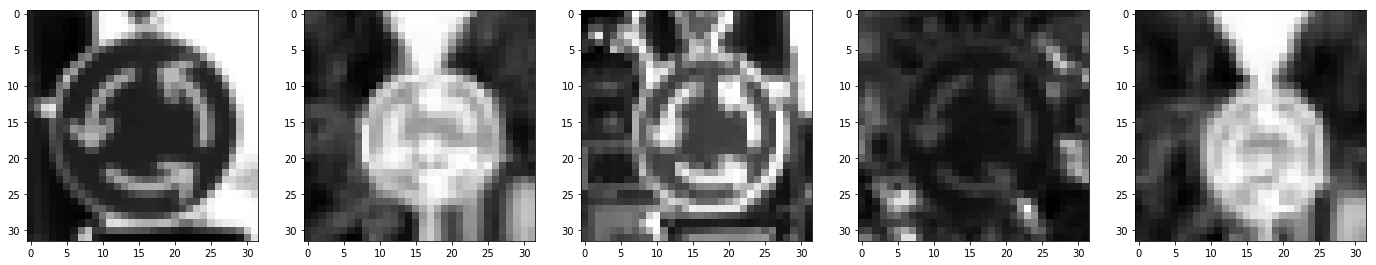

Double curve
{'f1-score': 0.745, 'precision': 0.982, 'recall': 0.6, 'support': 90}


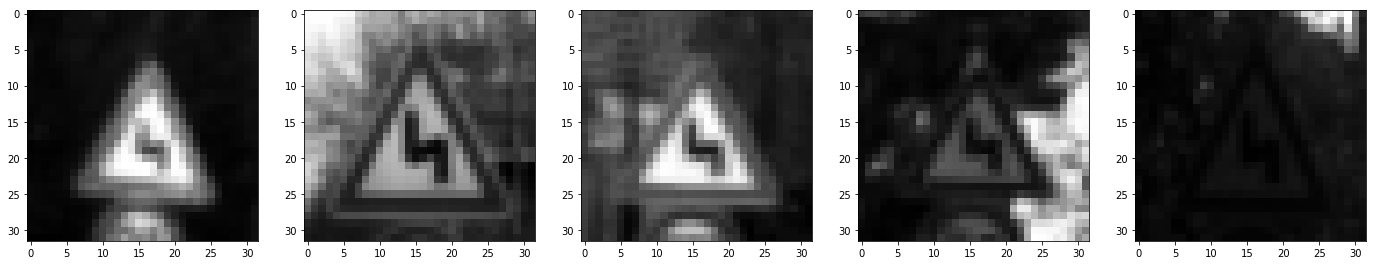

Beware of ice/snow
{'f1-score': 0.822, 'precision': 0.787, 'recall': 0.86, 'support': 150}


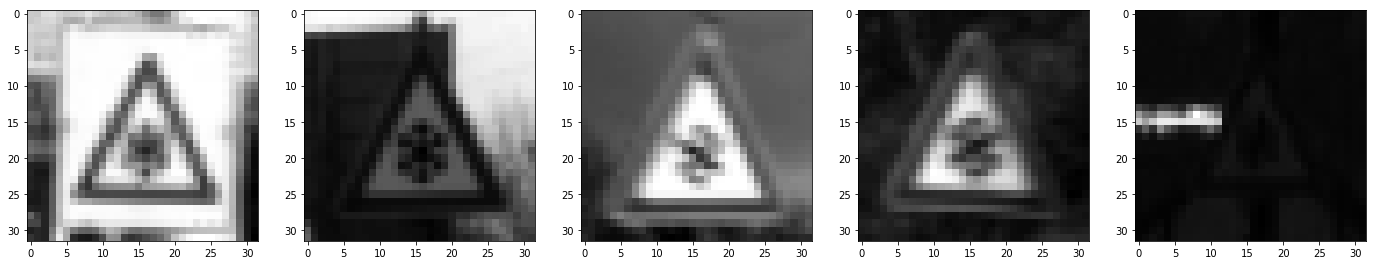

End of no passing
{'f1-score': 0.835, 'precision': 1.0, 'recall': 0.717, 'support': 60}


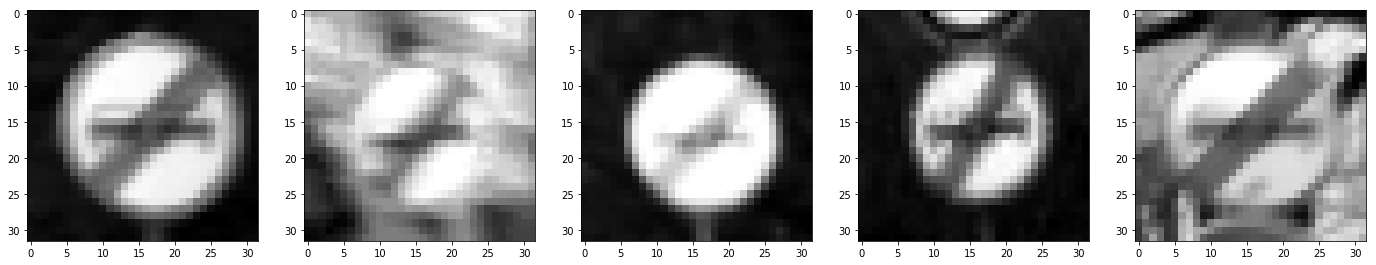

In [98]:
def print_precision_dict(dictionary):
    print({k:round(v,3) if isinstance(v,float) else v for k,v in dictionary.items()})
    
classification_report = {k: v for k, v in classification_report.items() if isinstance(v,dict)}

worst_score = min(classification_report.values(), key=lambda x: x['f1-score']) 

worsts_filter = filter(lambda x: x['f1-score'] < 0.85,classification_report.values())

worsts = list(worsts_filter)

for bad_score in worsts:
    bad_label = list(classification_report.keys())[
        list(classification_report.values()).index(bad_score)]
    
    print(bad_label)
    print_precision_dict(bad_score)

    bad_label_num = labels.loc[labels['SignName']==bad_label].iloc[0][0]

    bad_indices = np.where(training_set_labels == bad_label_num)

    plot_images(training_set_samples[bad_indices[0][0:5]])


## Considerations

Classification suffers in classifying *triangle-shape* images.

The neural network should enhance its geometrical recognition of such shapes 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [99]:
# Populate new test set labels

New Test Set Labels:  ['Priority road' 'Go straight or right' 'No passing'
 'Speed limit (50km/h)' 'Children crossing']


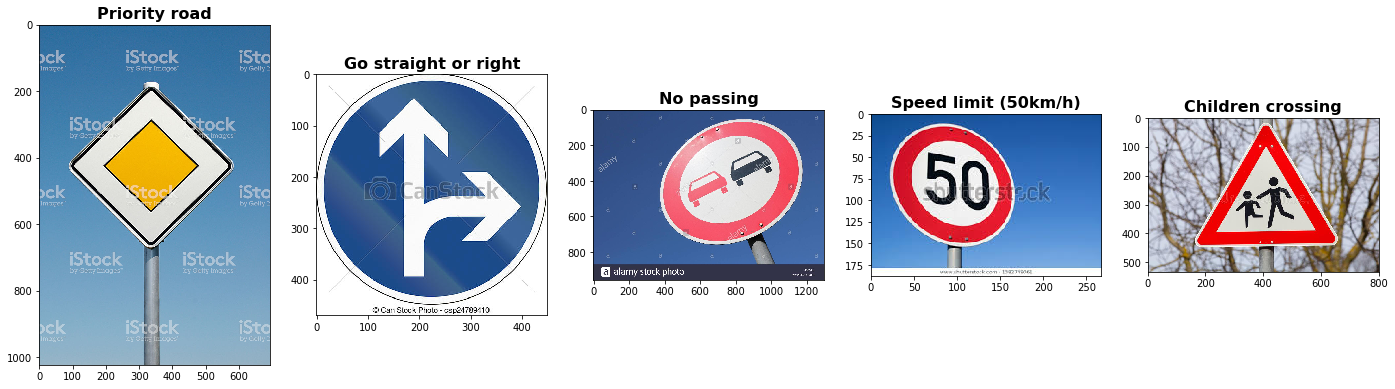

In [112]:
### Load the images and plot them here.

new_images_path = glob.glob('./web_images/*.jpg')
new_images = list()

for image_path in new_images_path:
    image = mpimg.imread(image_path)
    new_images.append(image)
    
new_test_set_labels_indices = list()

new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Priority road'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Go straight or right'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='No passing'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Speed limit (50km/h)'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Children crossing'].iloc[0][0])

new_test_set_labels = class_labels[new_test_set_labels_indices]
print('New Test Set Labels: ',new_test_set_labels)

plot_images(new_images, new_test_set_labels)


### Predict the Sign Type for Each Image

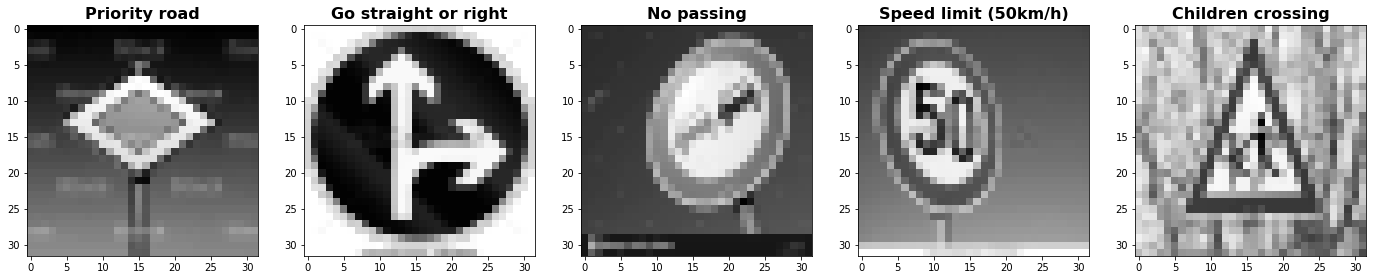

In [113]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

# PreProcessing

processed_new_images = list()

for image in new_images:
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA)
    processed_new_images.append(preprocess_image(image))

    
plot_images(processed_new_images, new_test_set_labels)


new_test_set_samples = processed_new_images
    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.


In [114]:
# Run the model on
k_num = 5
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_num)


def predict_batch(x_batch, y_batch):
    
    batch_top_k = list()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, tf.train.latest_checkpoint(output_path))
        top_k_result = sess.run(top_k, feed_dict={x:x_batch, y:y_batch, keep_prob:1.0})
        batch_top_k.append((top_k_result))
        
    return batch_top_k

        
top_k_predictions = predict_batch(new_test_set_samples, new_test_set_labels_indices)
print('Predictions over new test images completed!')

INFO:tensorflow:Restoring parameters from saved_model/lenet
Predictions over new test images completed!


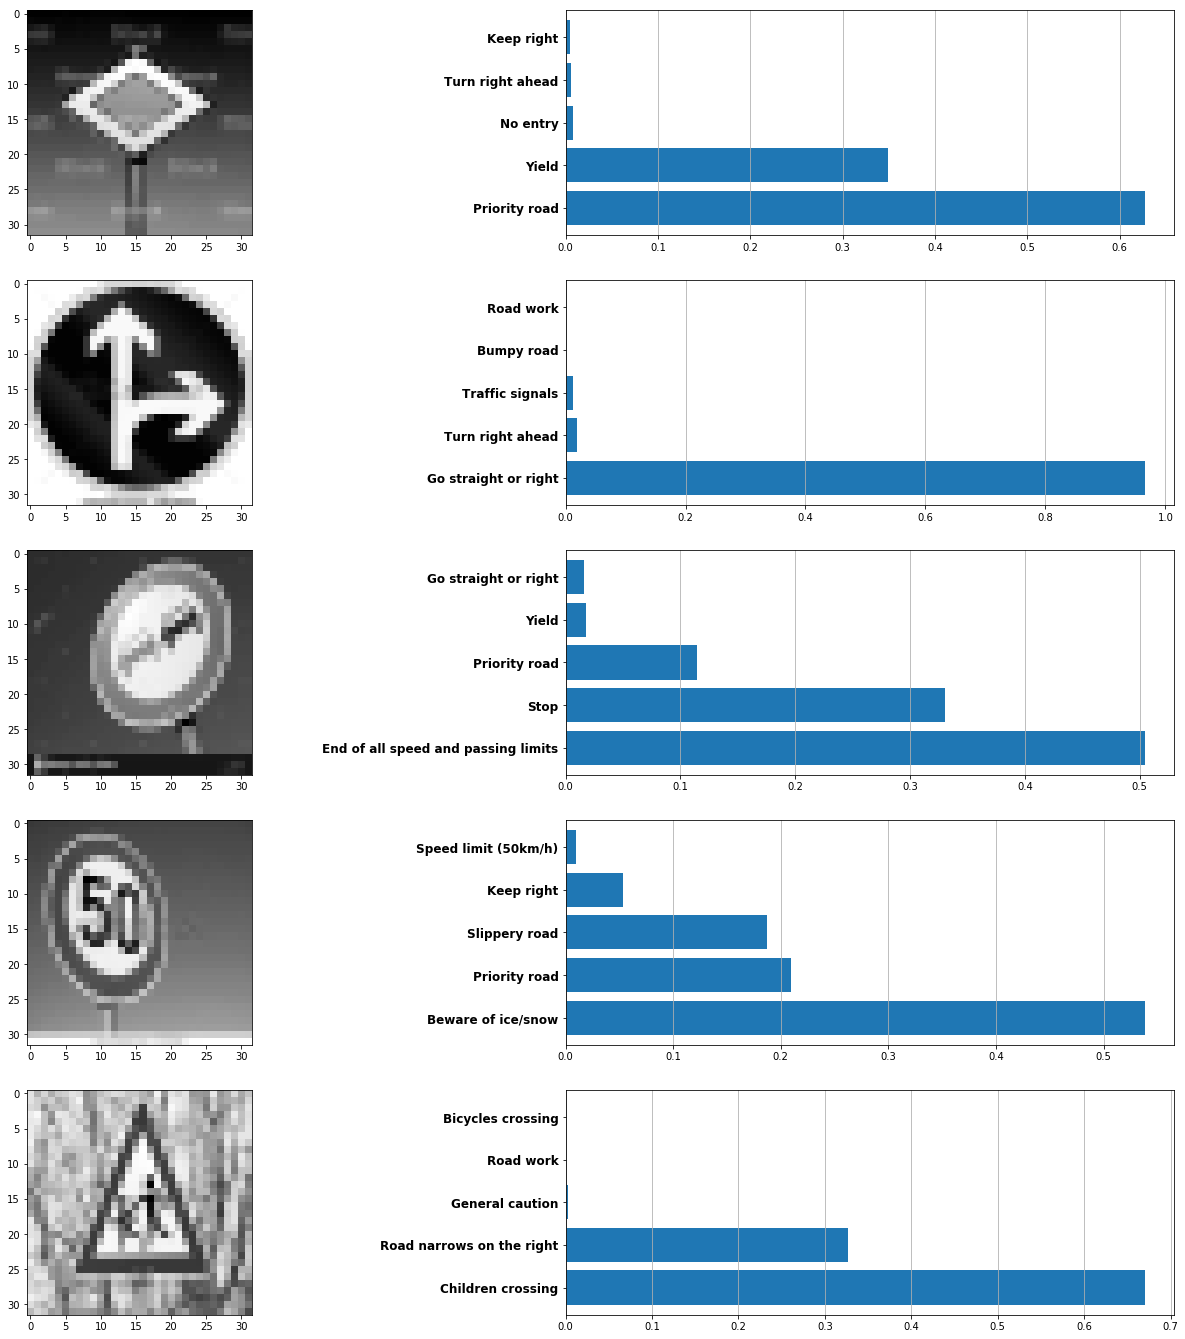

In [122]:
f,axes = plt.subplots(len(new_test_set_samples), 2, figsize=(24,24))

for ind,image in enumerate(new_test_set_samples):
    image_ax = axes[ind][0]
    top_k_ax = axes[ind][1]
    
    image_ax.imshow(image.squeeze(axis=2), cmap='gray')
    
    top_k_ax.barh(np.arange(0, 5, 1), top_k_predictions[0].values[ind])
        
    top_k_lab_num = top_k_predictions[0].indices[ind]

    top_k_labels = class_labels[top_k_predictions[0].indices[ind]]
    
    top_k_ax.grid(axis='x')
    top_k_ax.set_yticks(np.arange(0, 5, 1))
    top_k_ax.set_yticklabels(top_k_labels, {'fontweight':'bold', 'fontsize':12})


### Analyze Performance

In [116]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(output_path))
    
    new_test_accuracy = evaluate(new_test_set_samples, new_test_set_labels_indices)
    print("New Test Set Accuracy = {:.3f}".format(new_test_accuracy))



INFO:tensorflow:Restoring parameters from saved_model/lenet
New Test Set Accuracy = 0.600


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 : Visualize the Neural Network's State with Test Images


INFO:tensorflow:Restoring parameters from saved_model/lenet
Test Image :  Traffic signals


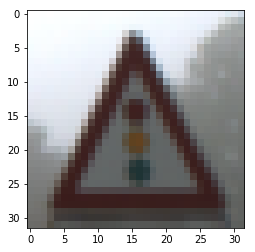

INFO:tensorflow:Restoring parameters from saved_model/lenet
Test Image :  Speed limit (50km/h)


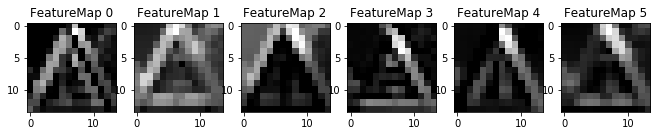

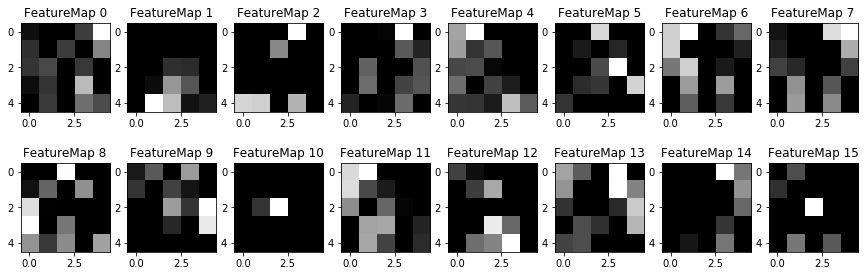

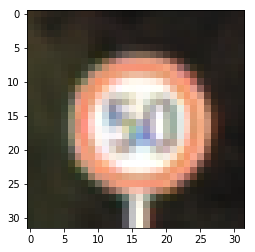

INFO:tensorflow:Restoring parameters from saved_model/lenet
Test Image :  No entry


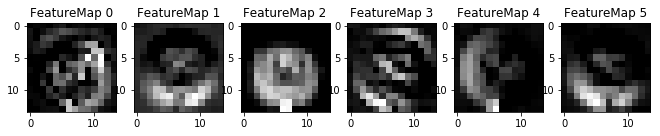

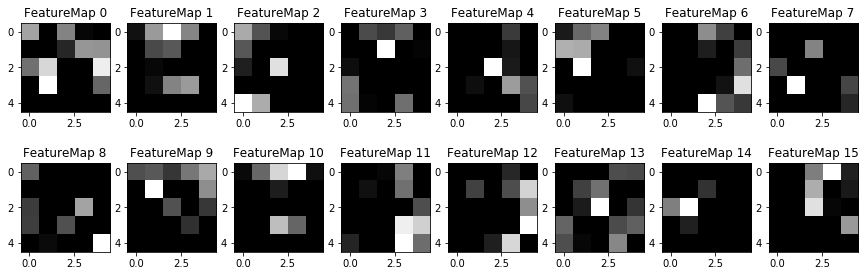

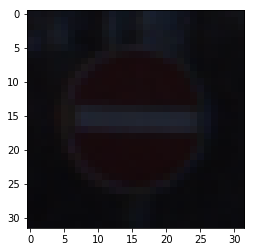

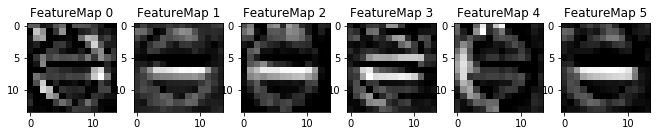

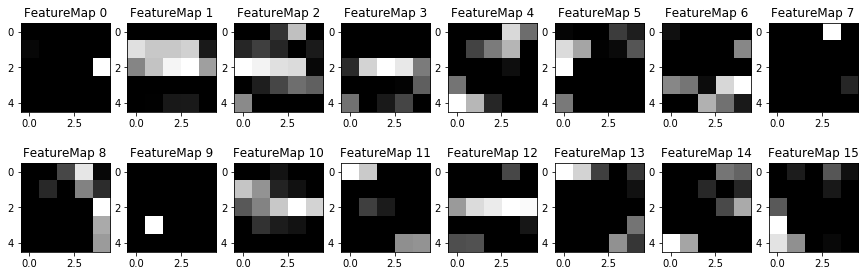

In [126]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input = preprocess_image(image_input)
    image_input = np.expand_dims(image_input, axis=0)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

indices = np.random.randint(0, n_train, size=3)
sample_images = training_set_samples_loaded[indices]
sample_labels = class_labels[training_set_labels[indices]]

for ind, test_fmap_image in enumerate(sample_images):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(output_path))
        # Test image visualization
        print('Test Image : ', sample_labels[ind])
        f, a = plt.subplots()
        a.imshow(test_fmap_image)
        plt.show()
        # First convolutional layer feature map
        outputFeatureMap(test_fmap_image, conv1, plt_num=1)
        
        # Second convolutional layer feature map
        outputFeatureMap(test_fmap_image, conv2, plt_num=2)
    
